# Advanced Defect Analysis

Here we describe some more targeted analysis you can do for your defect calculations parsed with `doped` (including comparing the relaxed configurations for different initial interstitial positions, structure & bond length analysis of defects, and plotting/analysis of the defect charge corrections), which may be useful for in certain cases.

```{tip}
You can run this notebook interactively through [Google Colab](https://colab.research.google.com/github/SMTG-Bham/doped/blob/develop/examples/advanced_analysis_tutorial.ipynb) or [Binder](https://mybinder.org/v2/gh/SMTG-Bham/doped/develop?urlpath=tree/examples/advanced_analysis_tutorial.ipynb) – just click the links!
If running on Colab, then you'll need to run `!pip install doped` in a cell to install the package, and `!git clone https://github.com/SMTG-Bham/doped` to download the example data (and update paths in the code cells accordingly).
```

## Defect-Induced Site Displacements (Strain)

Using the `DefectEntry.plot_site_displacements()` method, we can analyse the displacements of atoms around the defect site (i.e. defect-induced local strain) during geometry relaxation.

In [1]:
%matplotlib inline
from monty.serialization import loadfn
CdTe_defects_thermo = loadfn("CdTe/CdTe_thermo_wout_meta.json")  # load our DefectThermodynamics object

Let's look at the displacements of atoms around the Cd vacancy in CdTe, and how this changes with charge state:

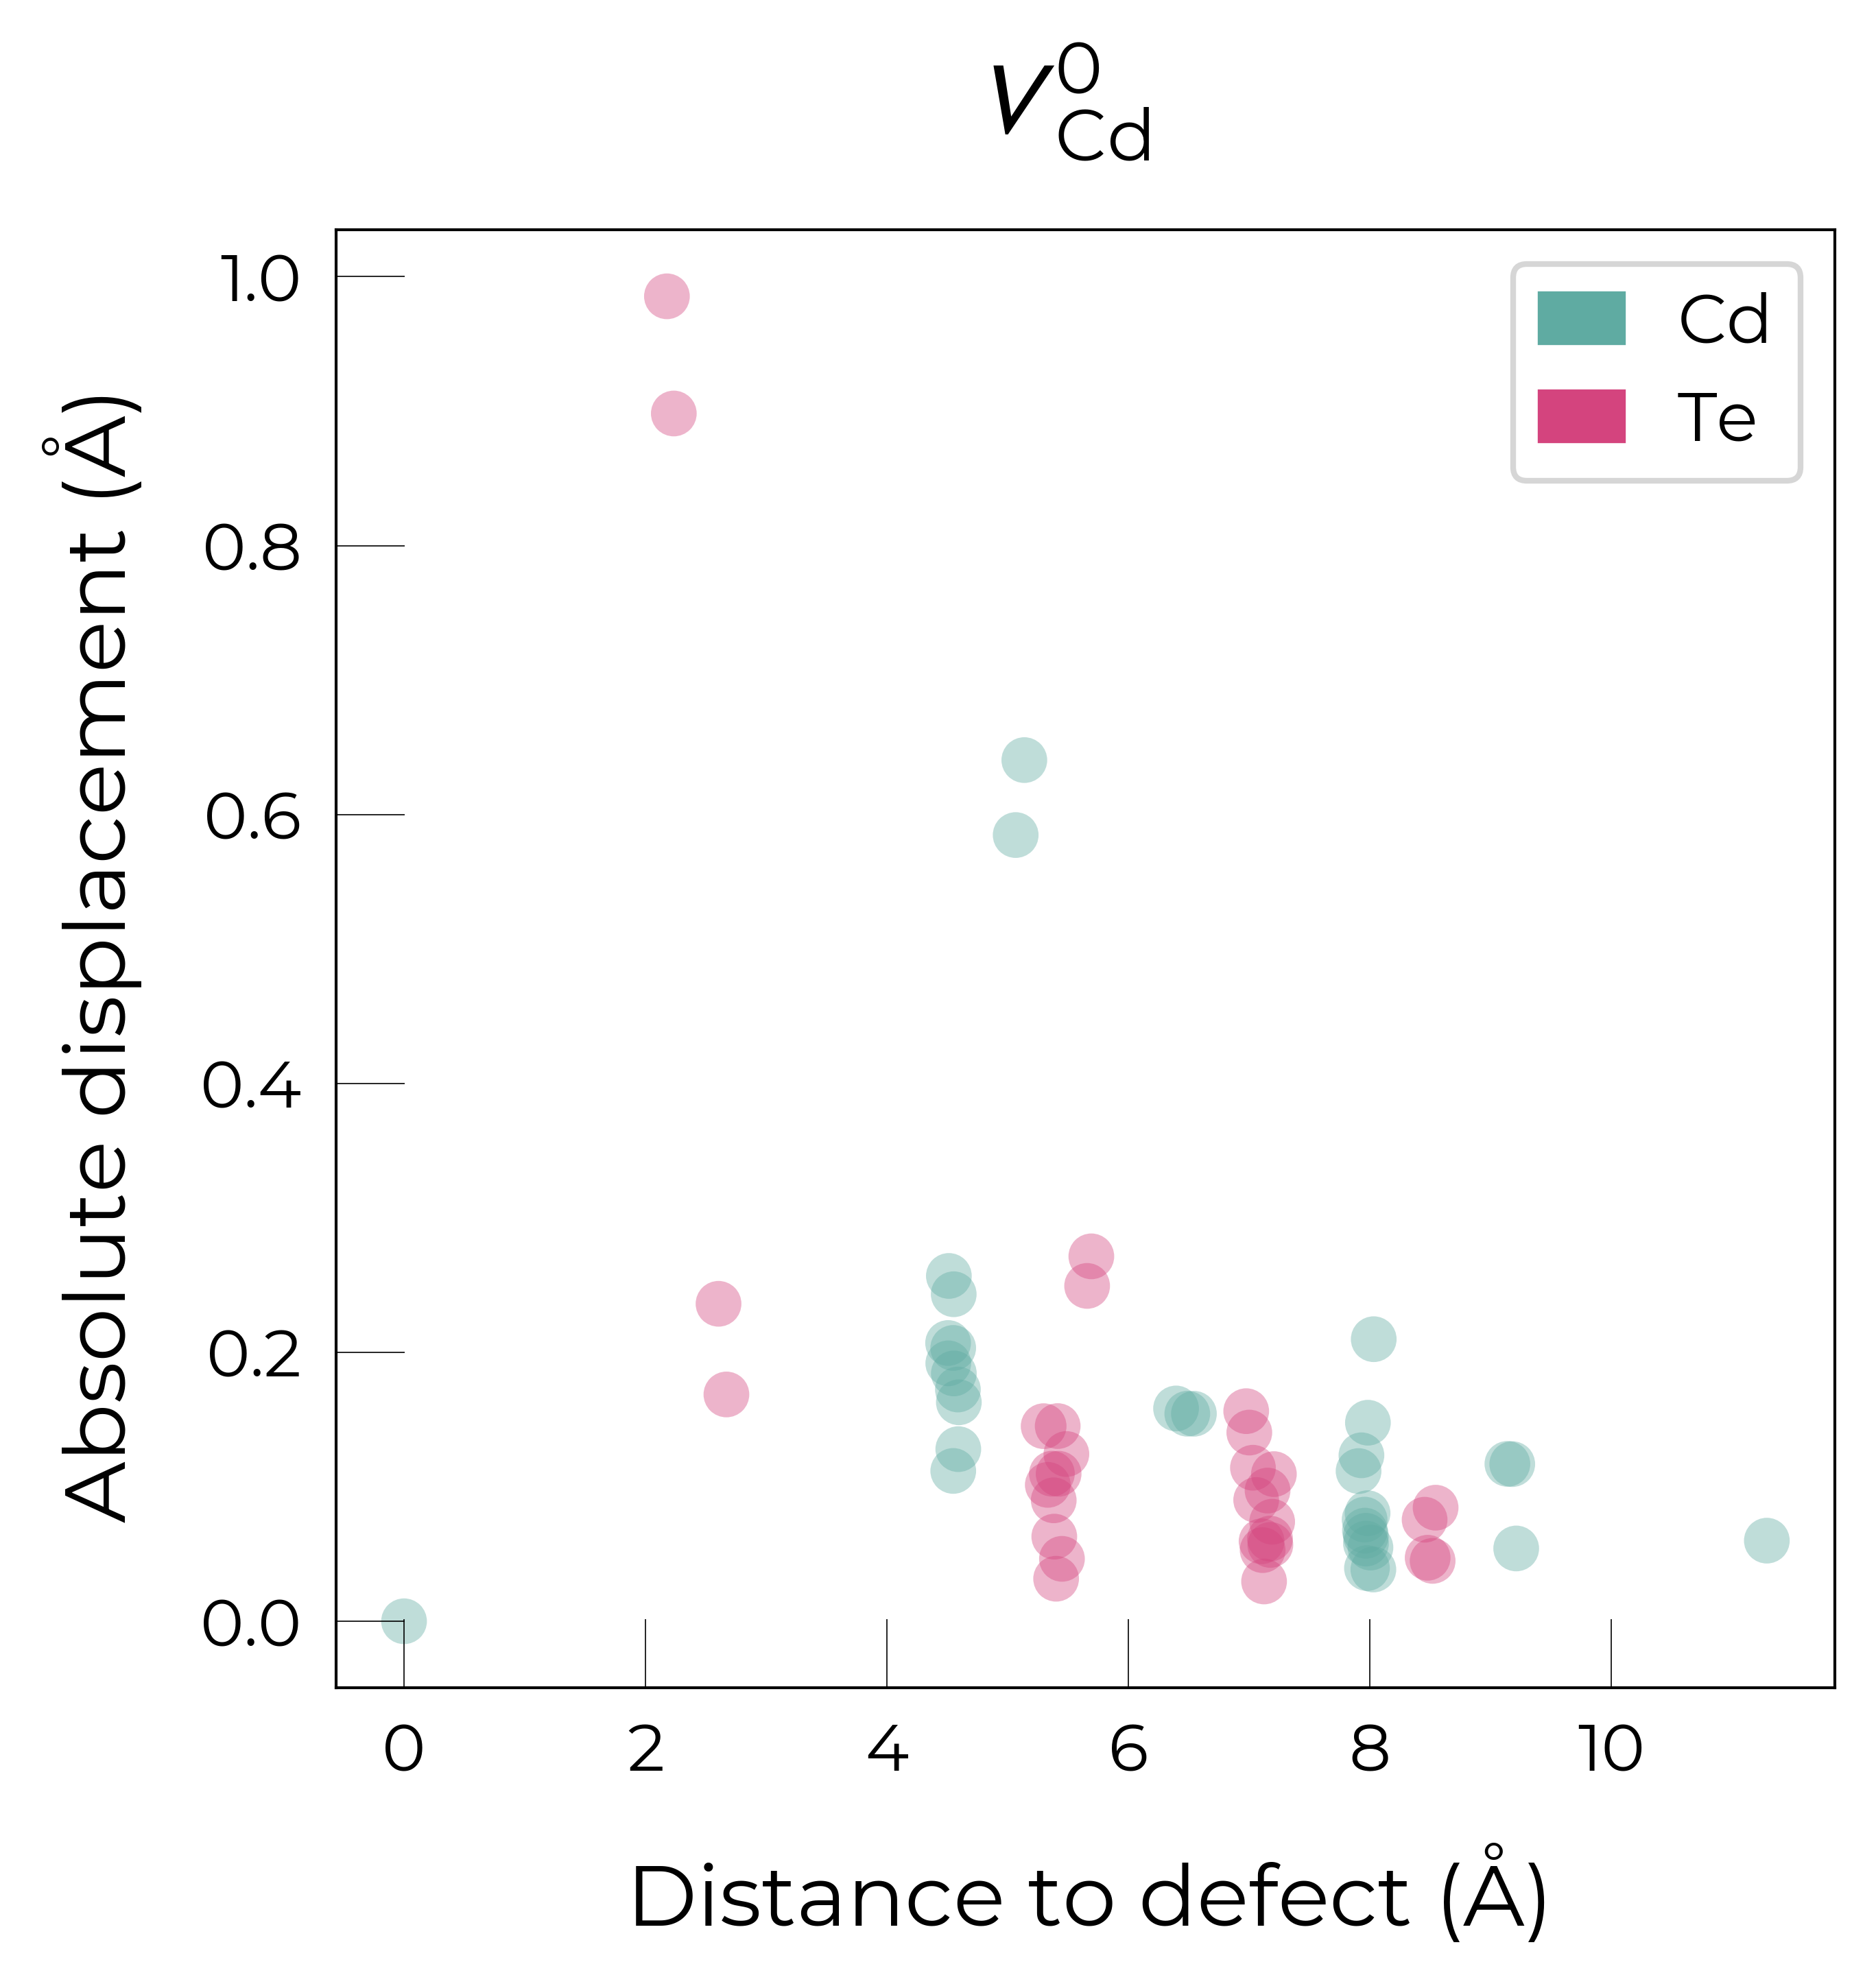

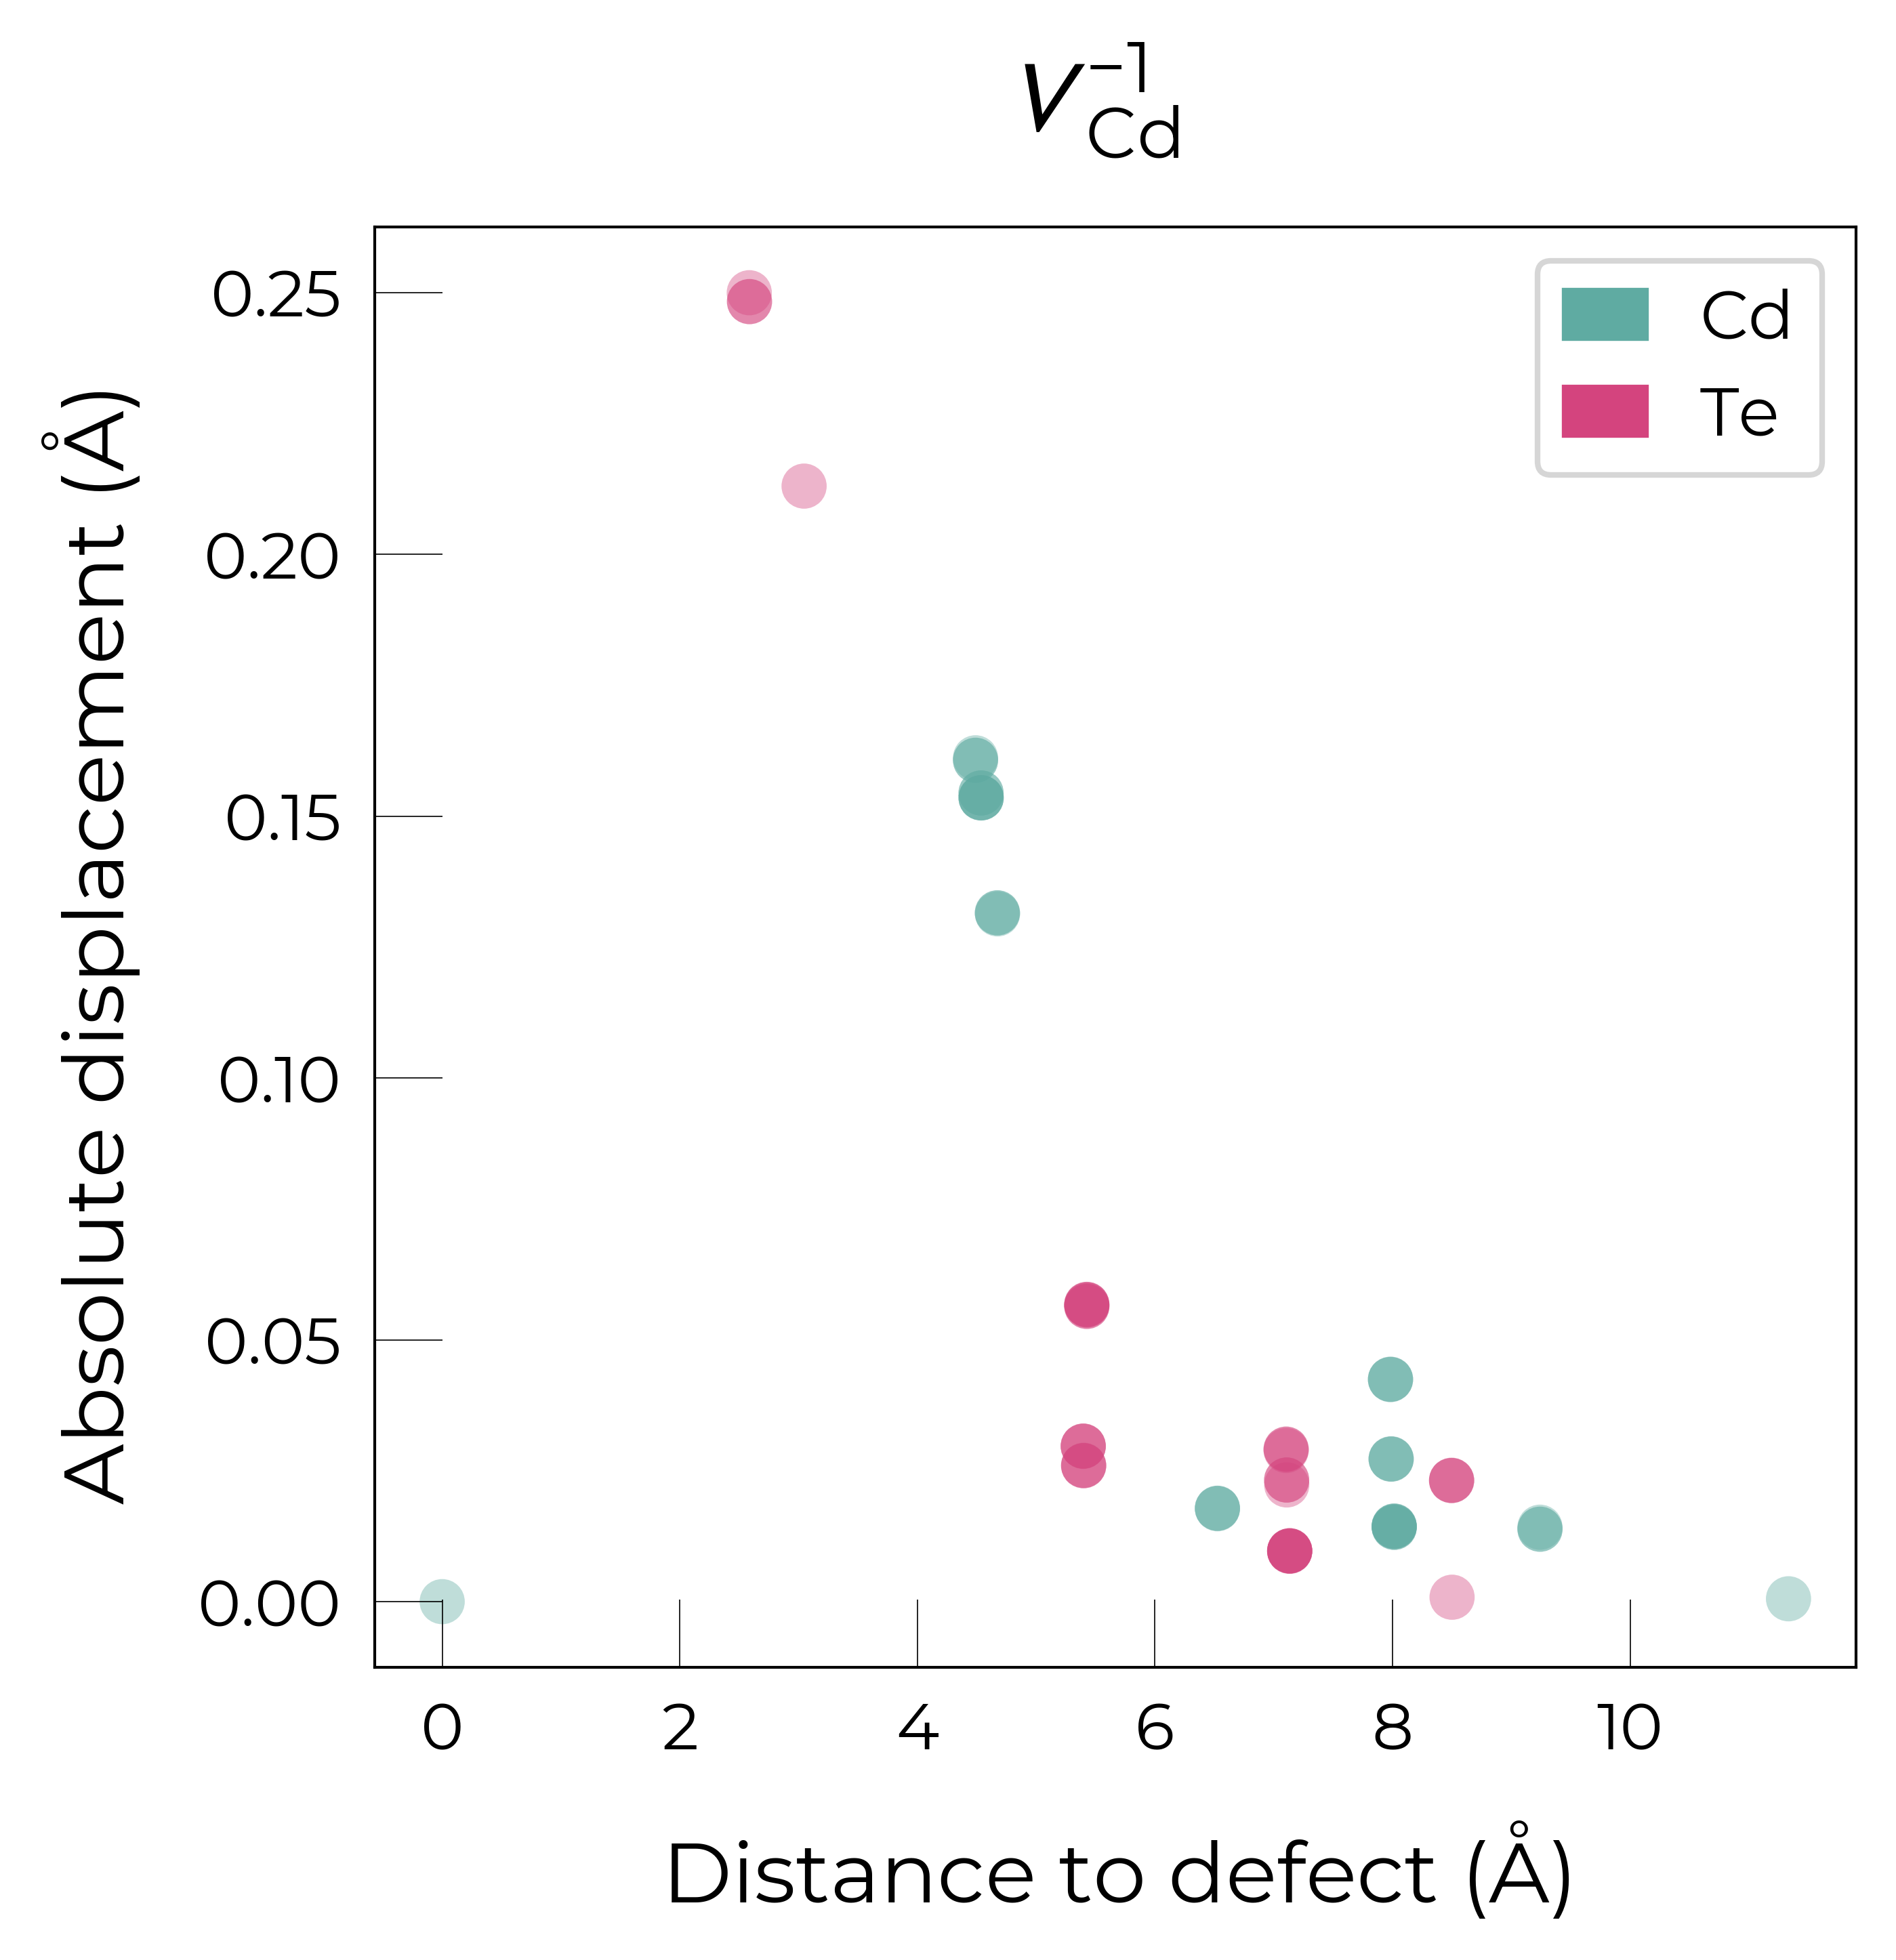

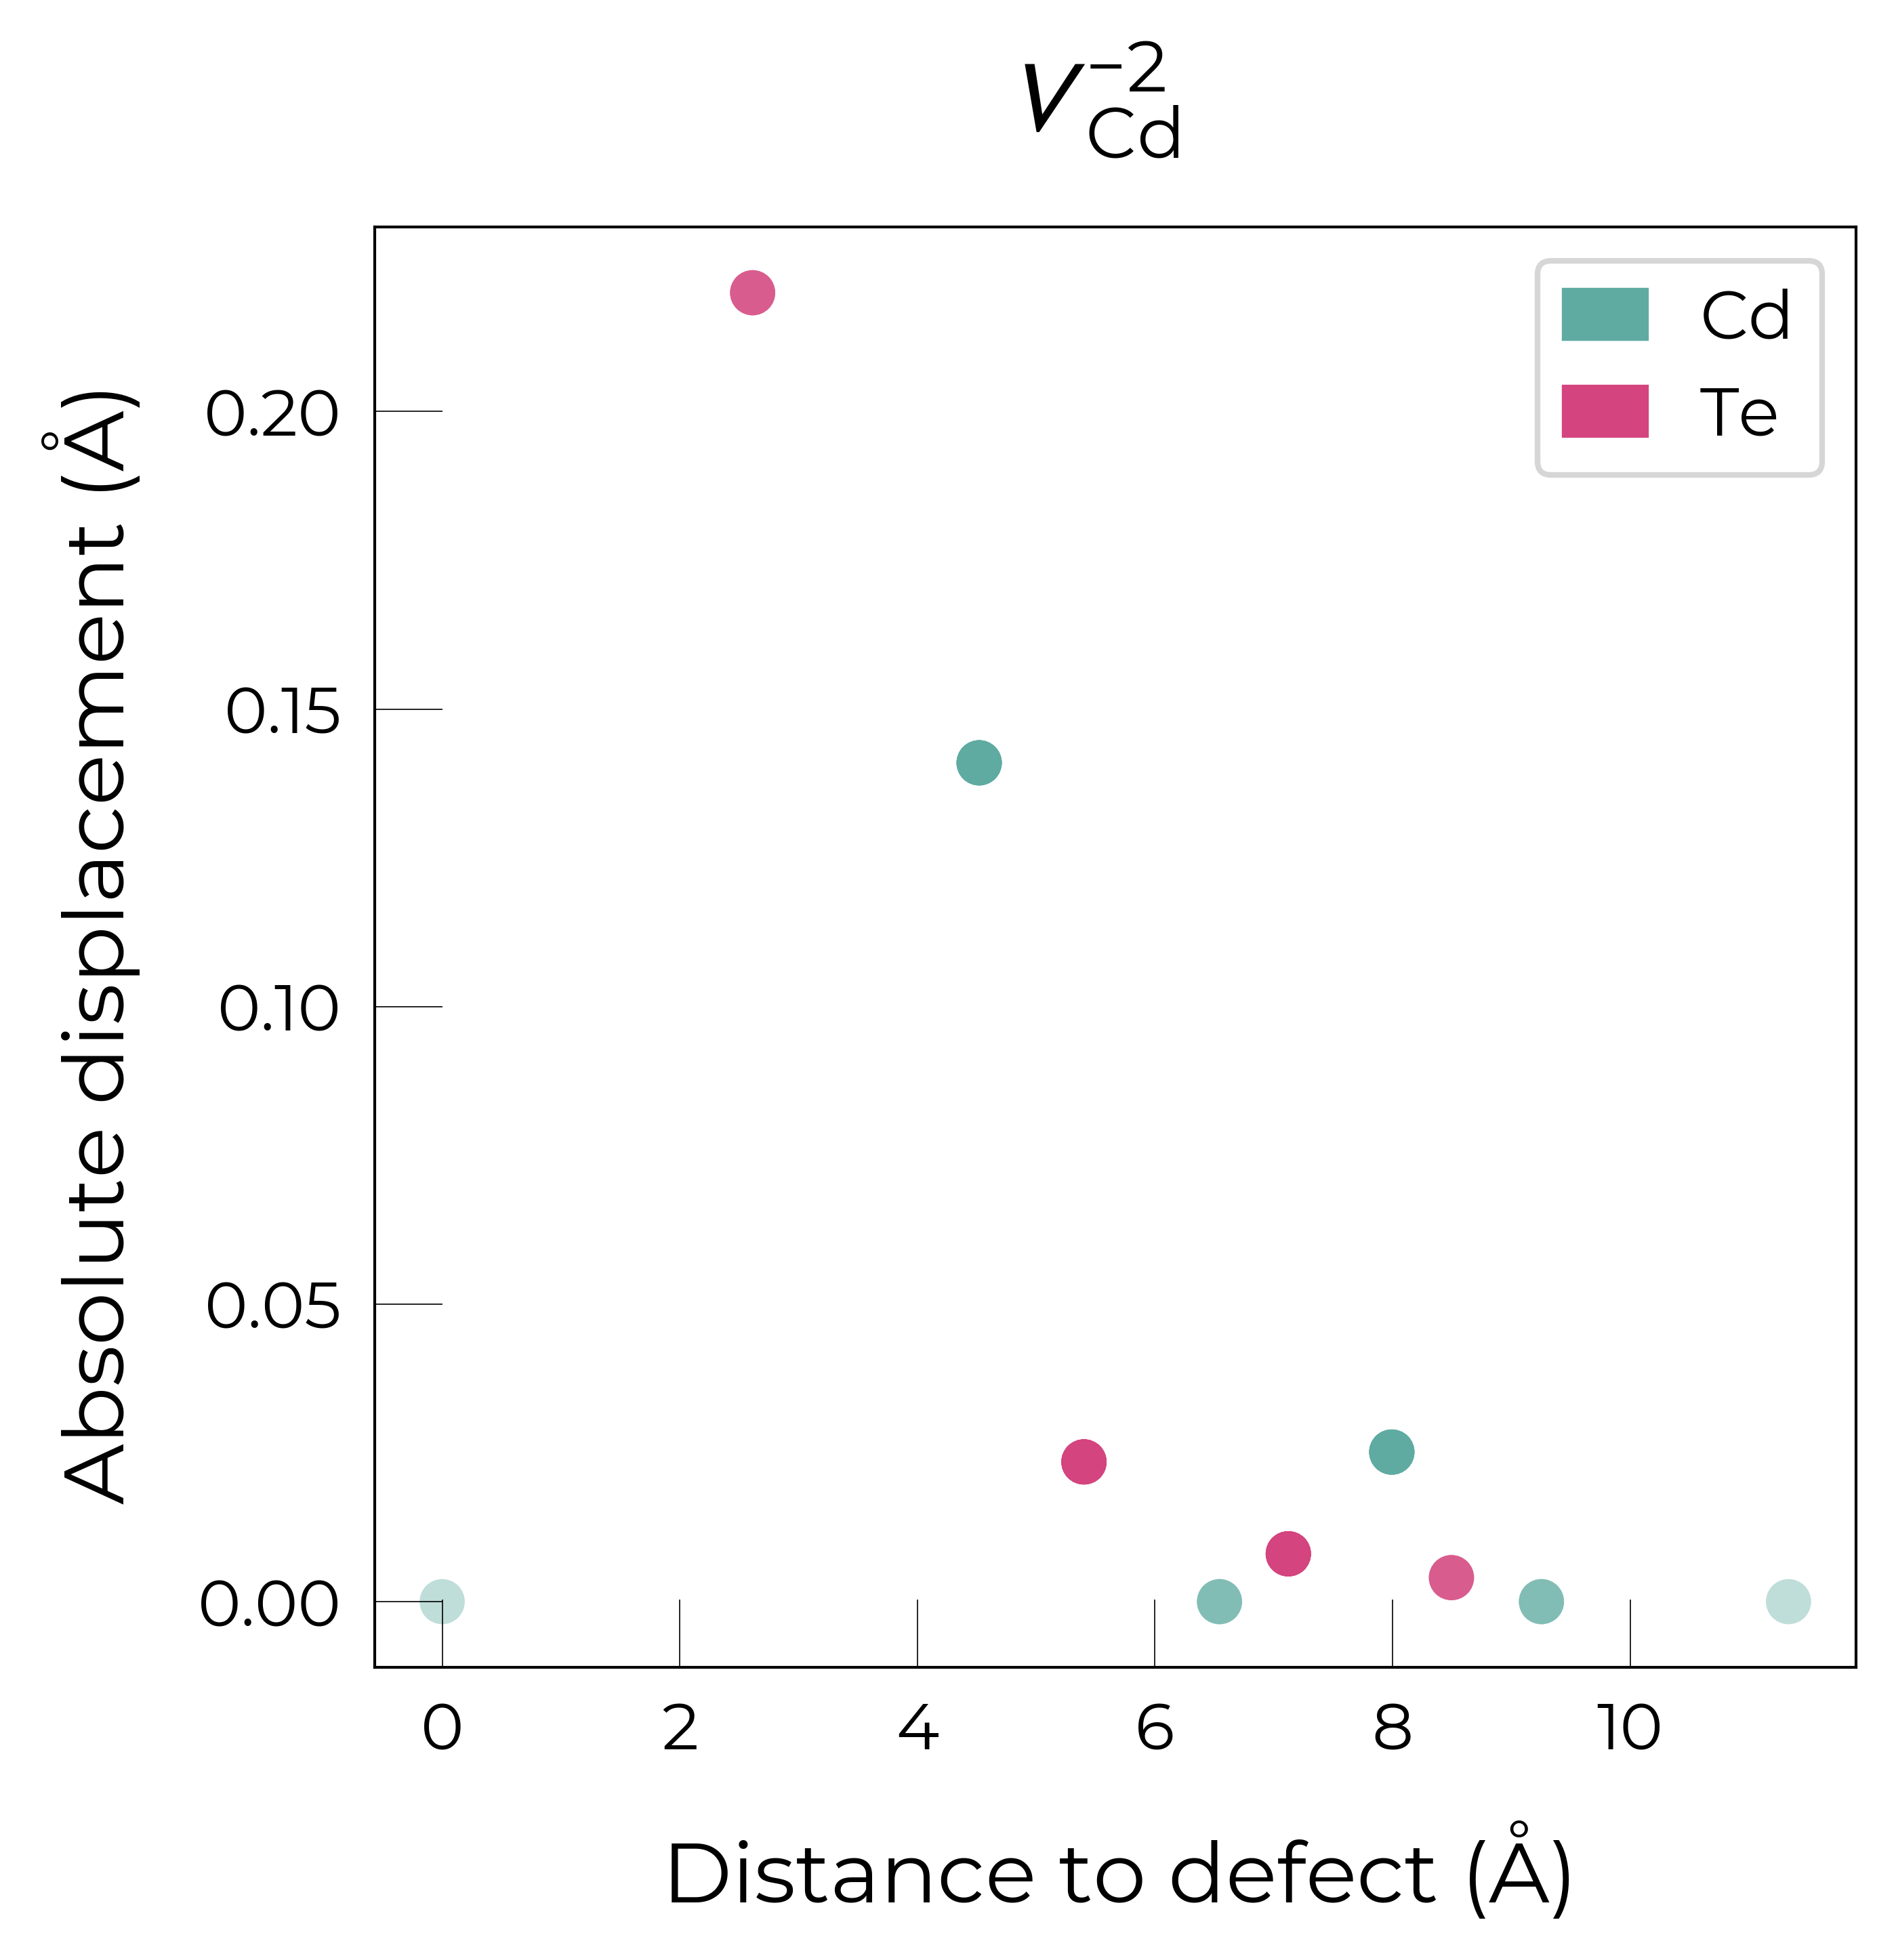

In [2]:
from doped.utils.plotting import format_defect_name

v_Cd_entries = [entry for entry in CdTe_defects_thermo.defect_entries if "v_Cd" in entry.name]
for defect_entry in v_Cd_entries:
    fig = defect_entry.plot_site_displacements(separated_by_direction=False)
    fig.suptitle(format_defect_name(defect_entry.name, include_site_info_in_name=False),
                 fontsize=18)

Separated by direction:

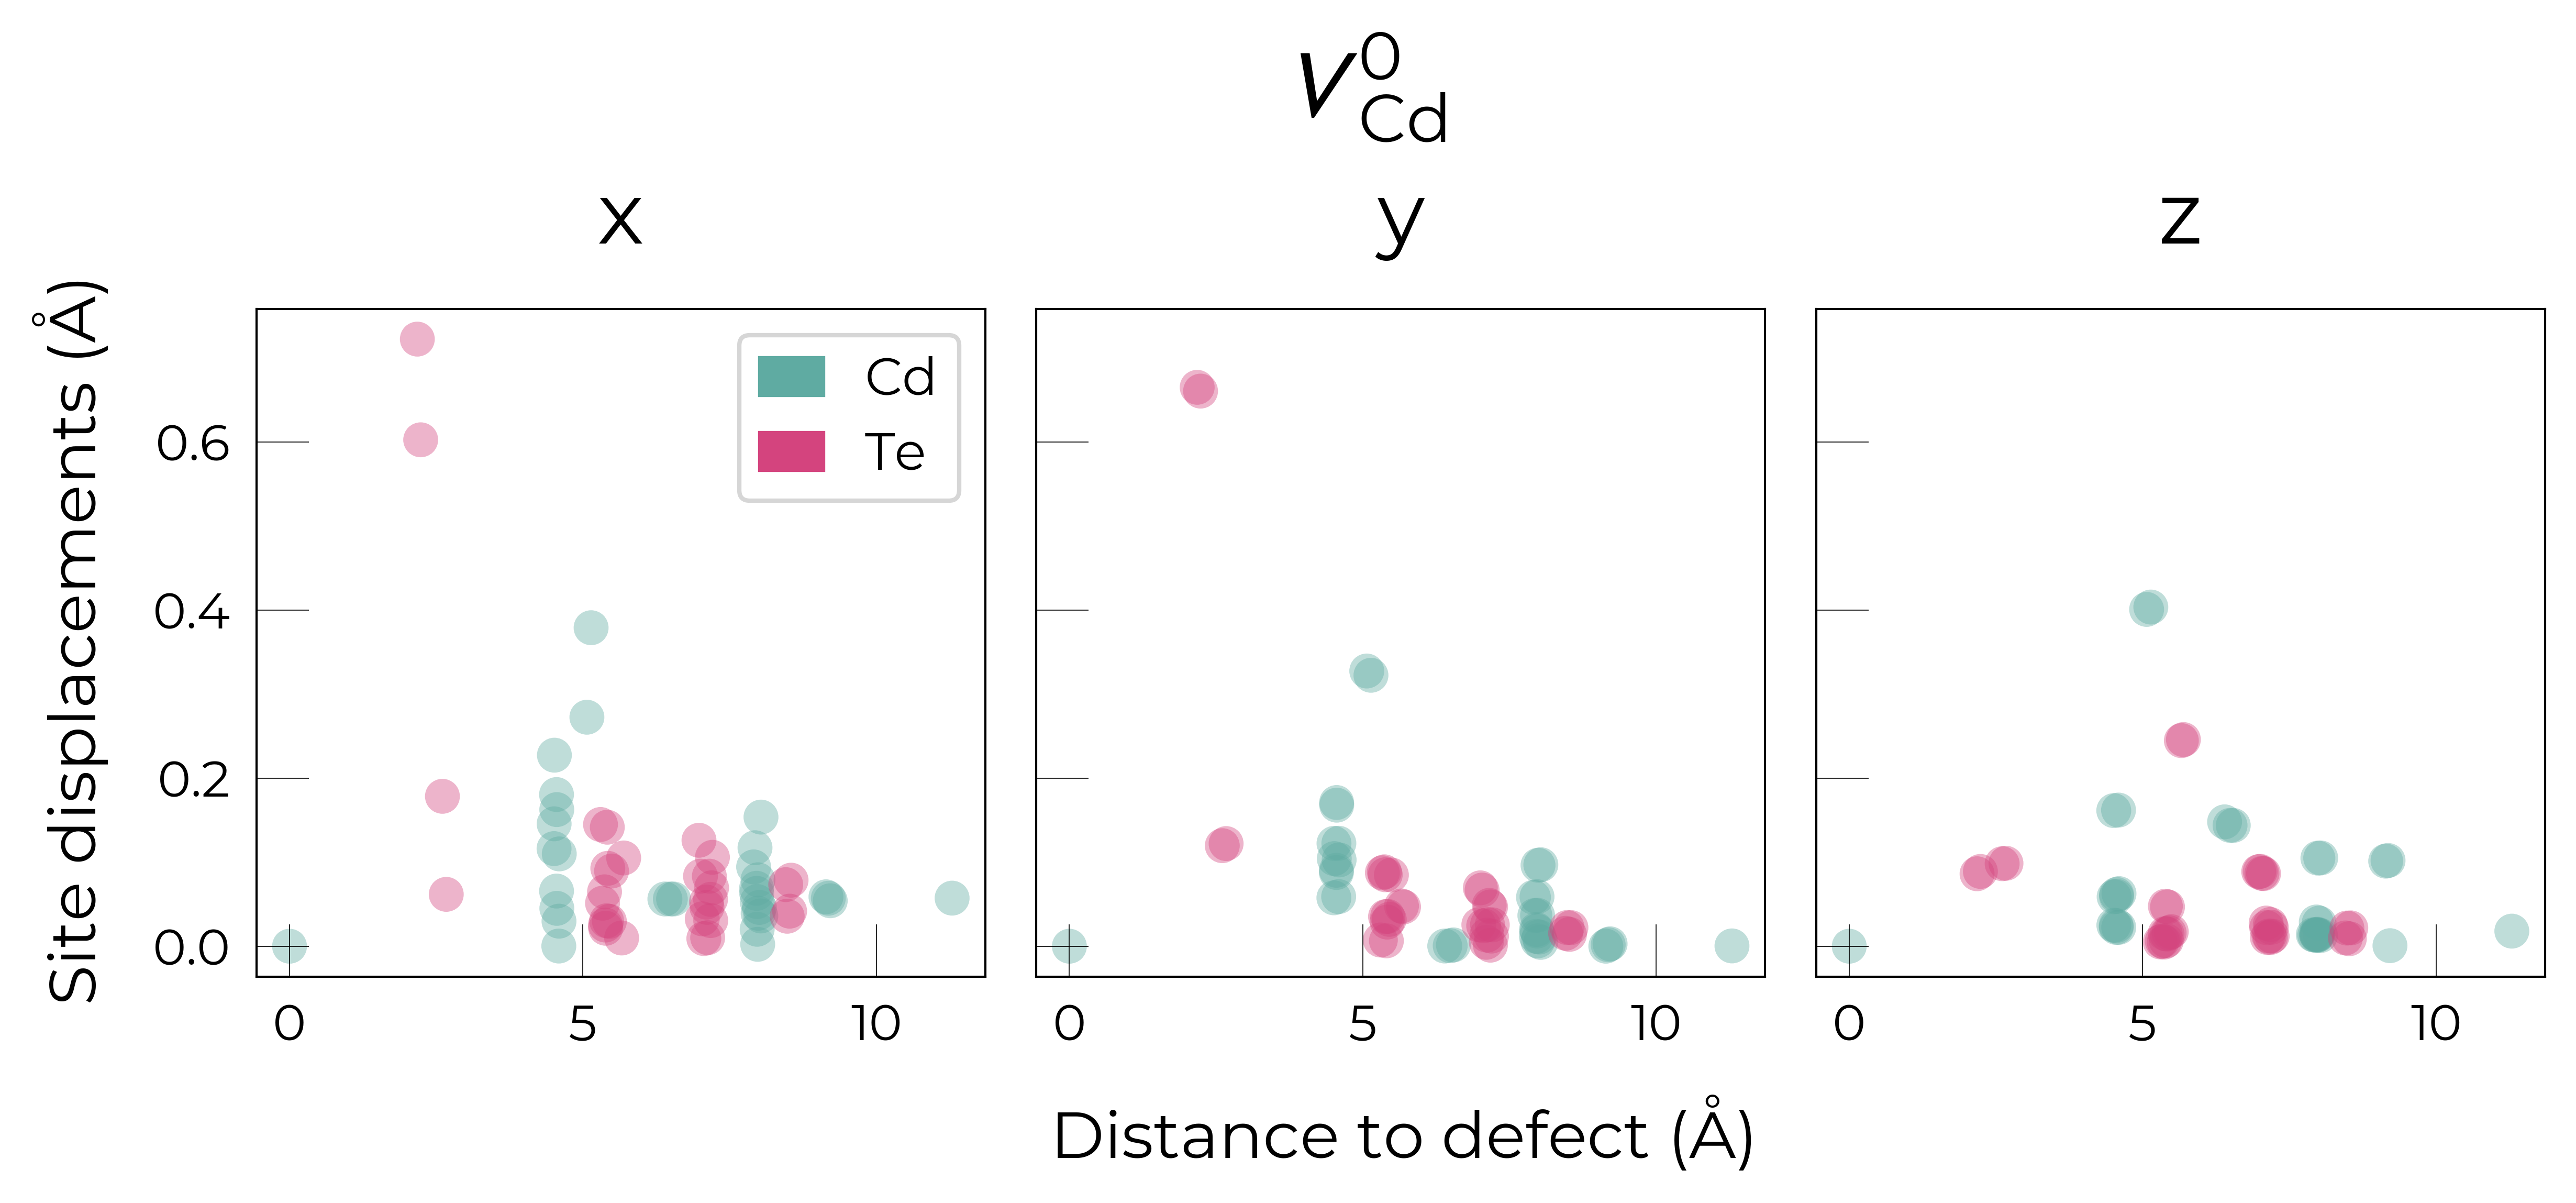

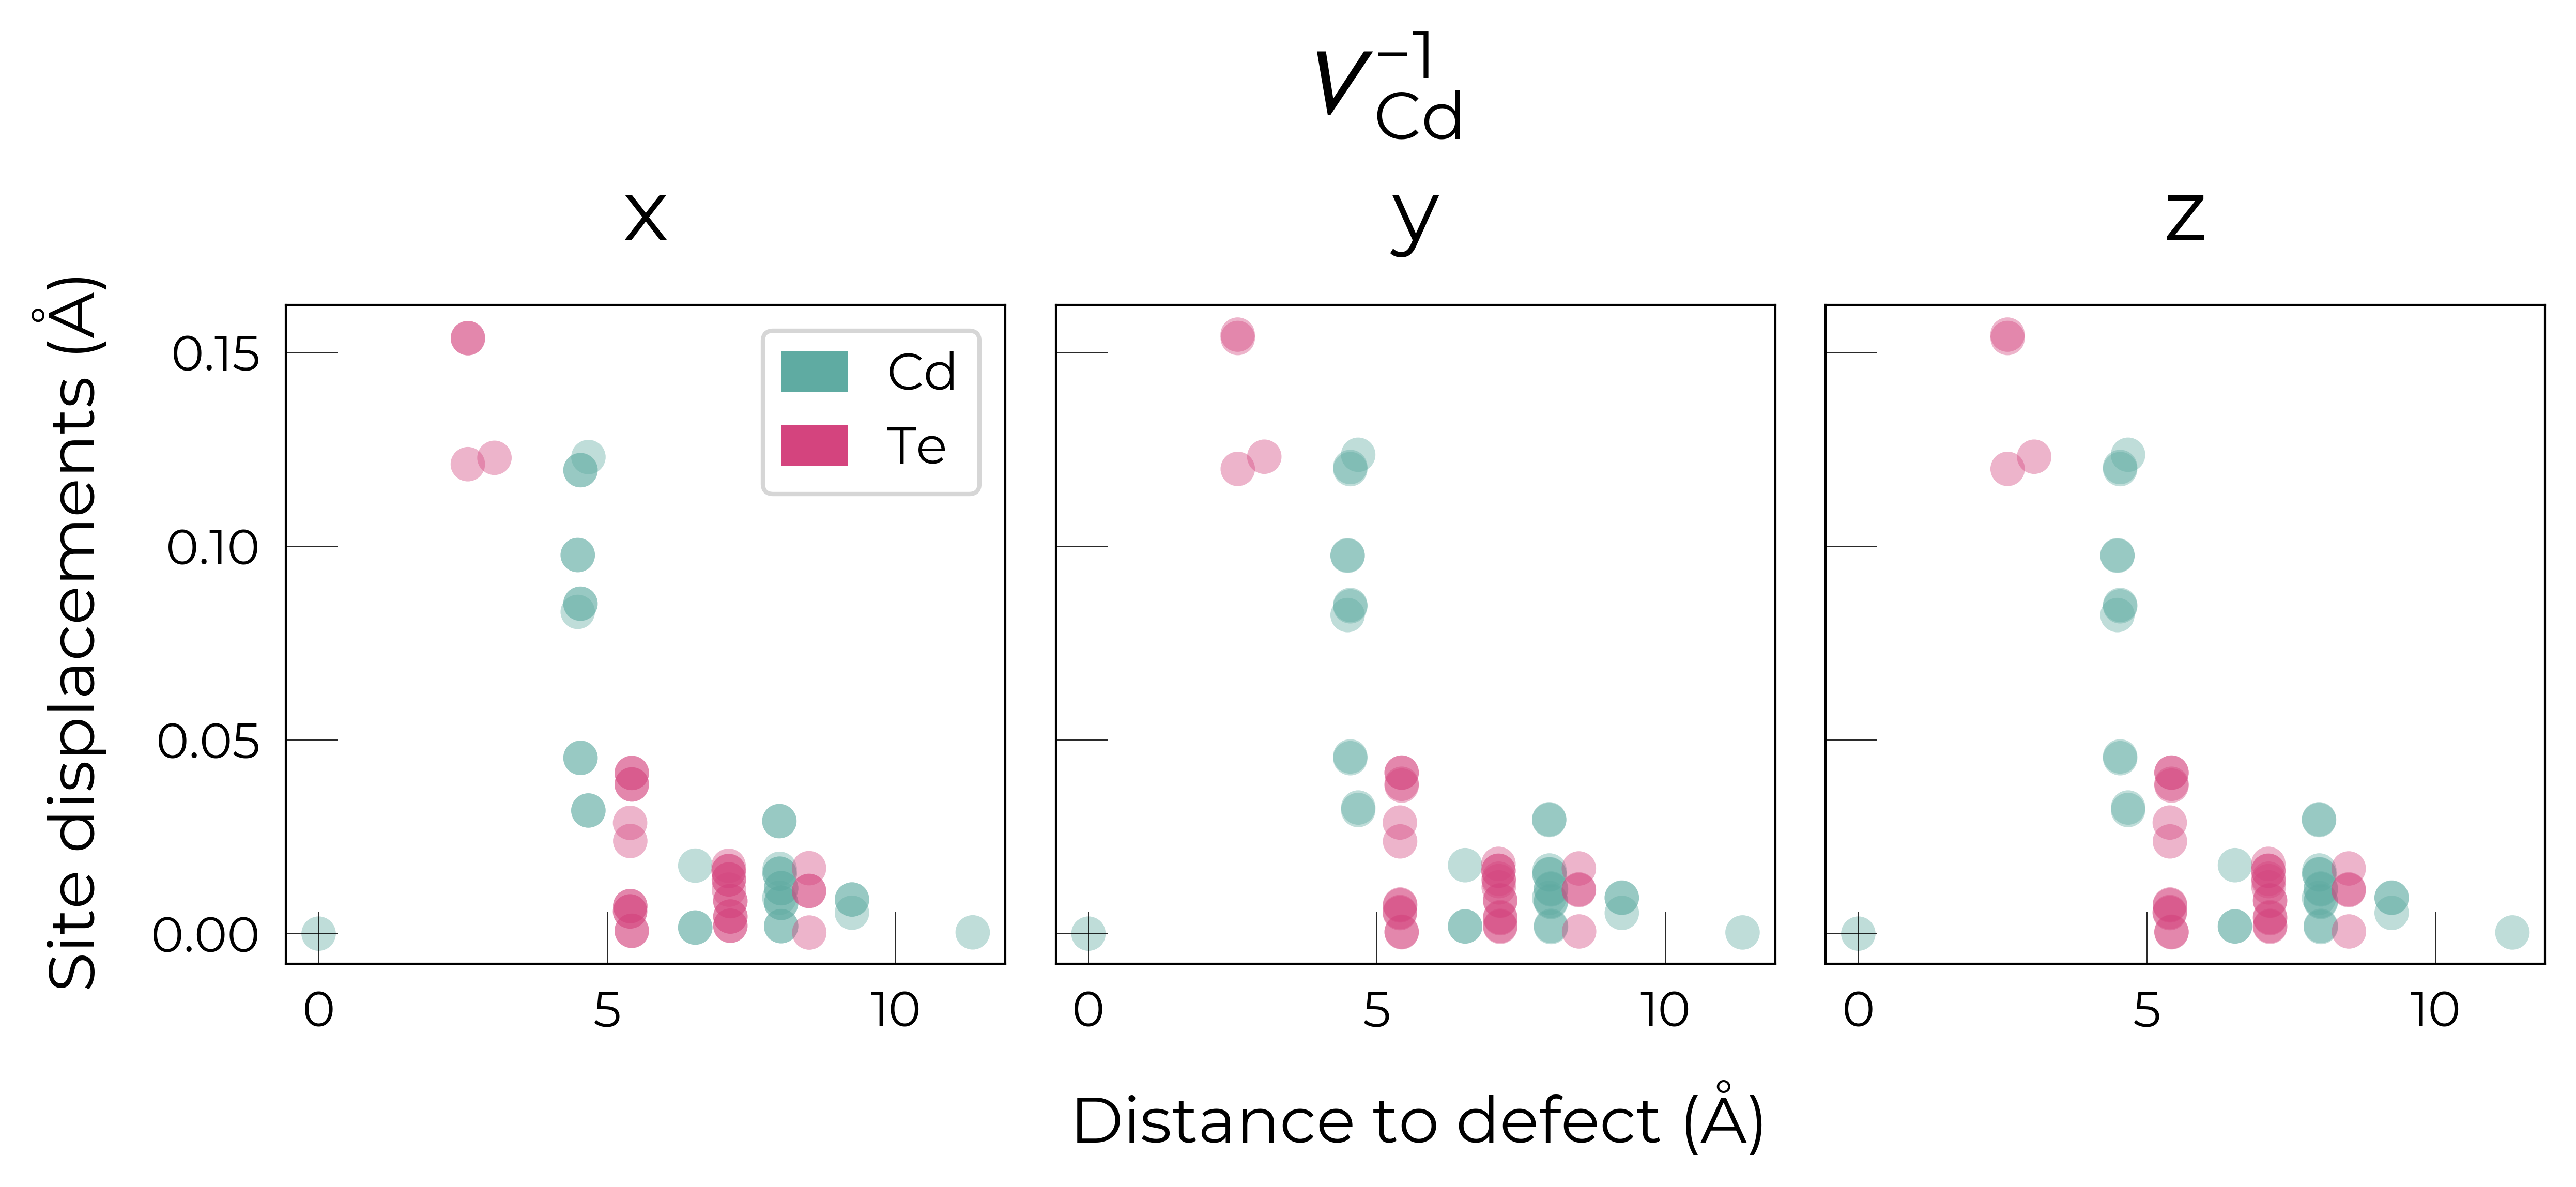

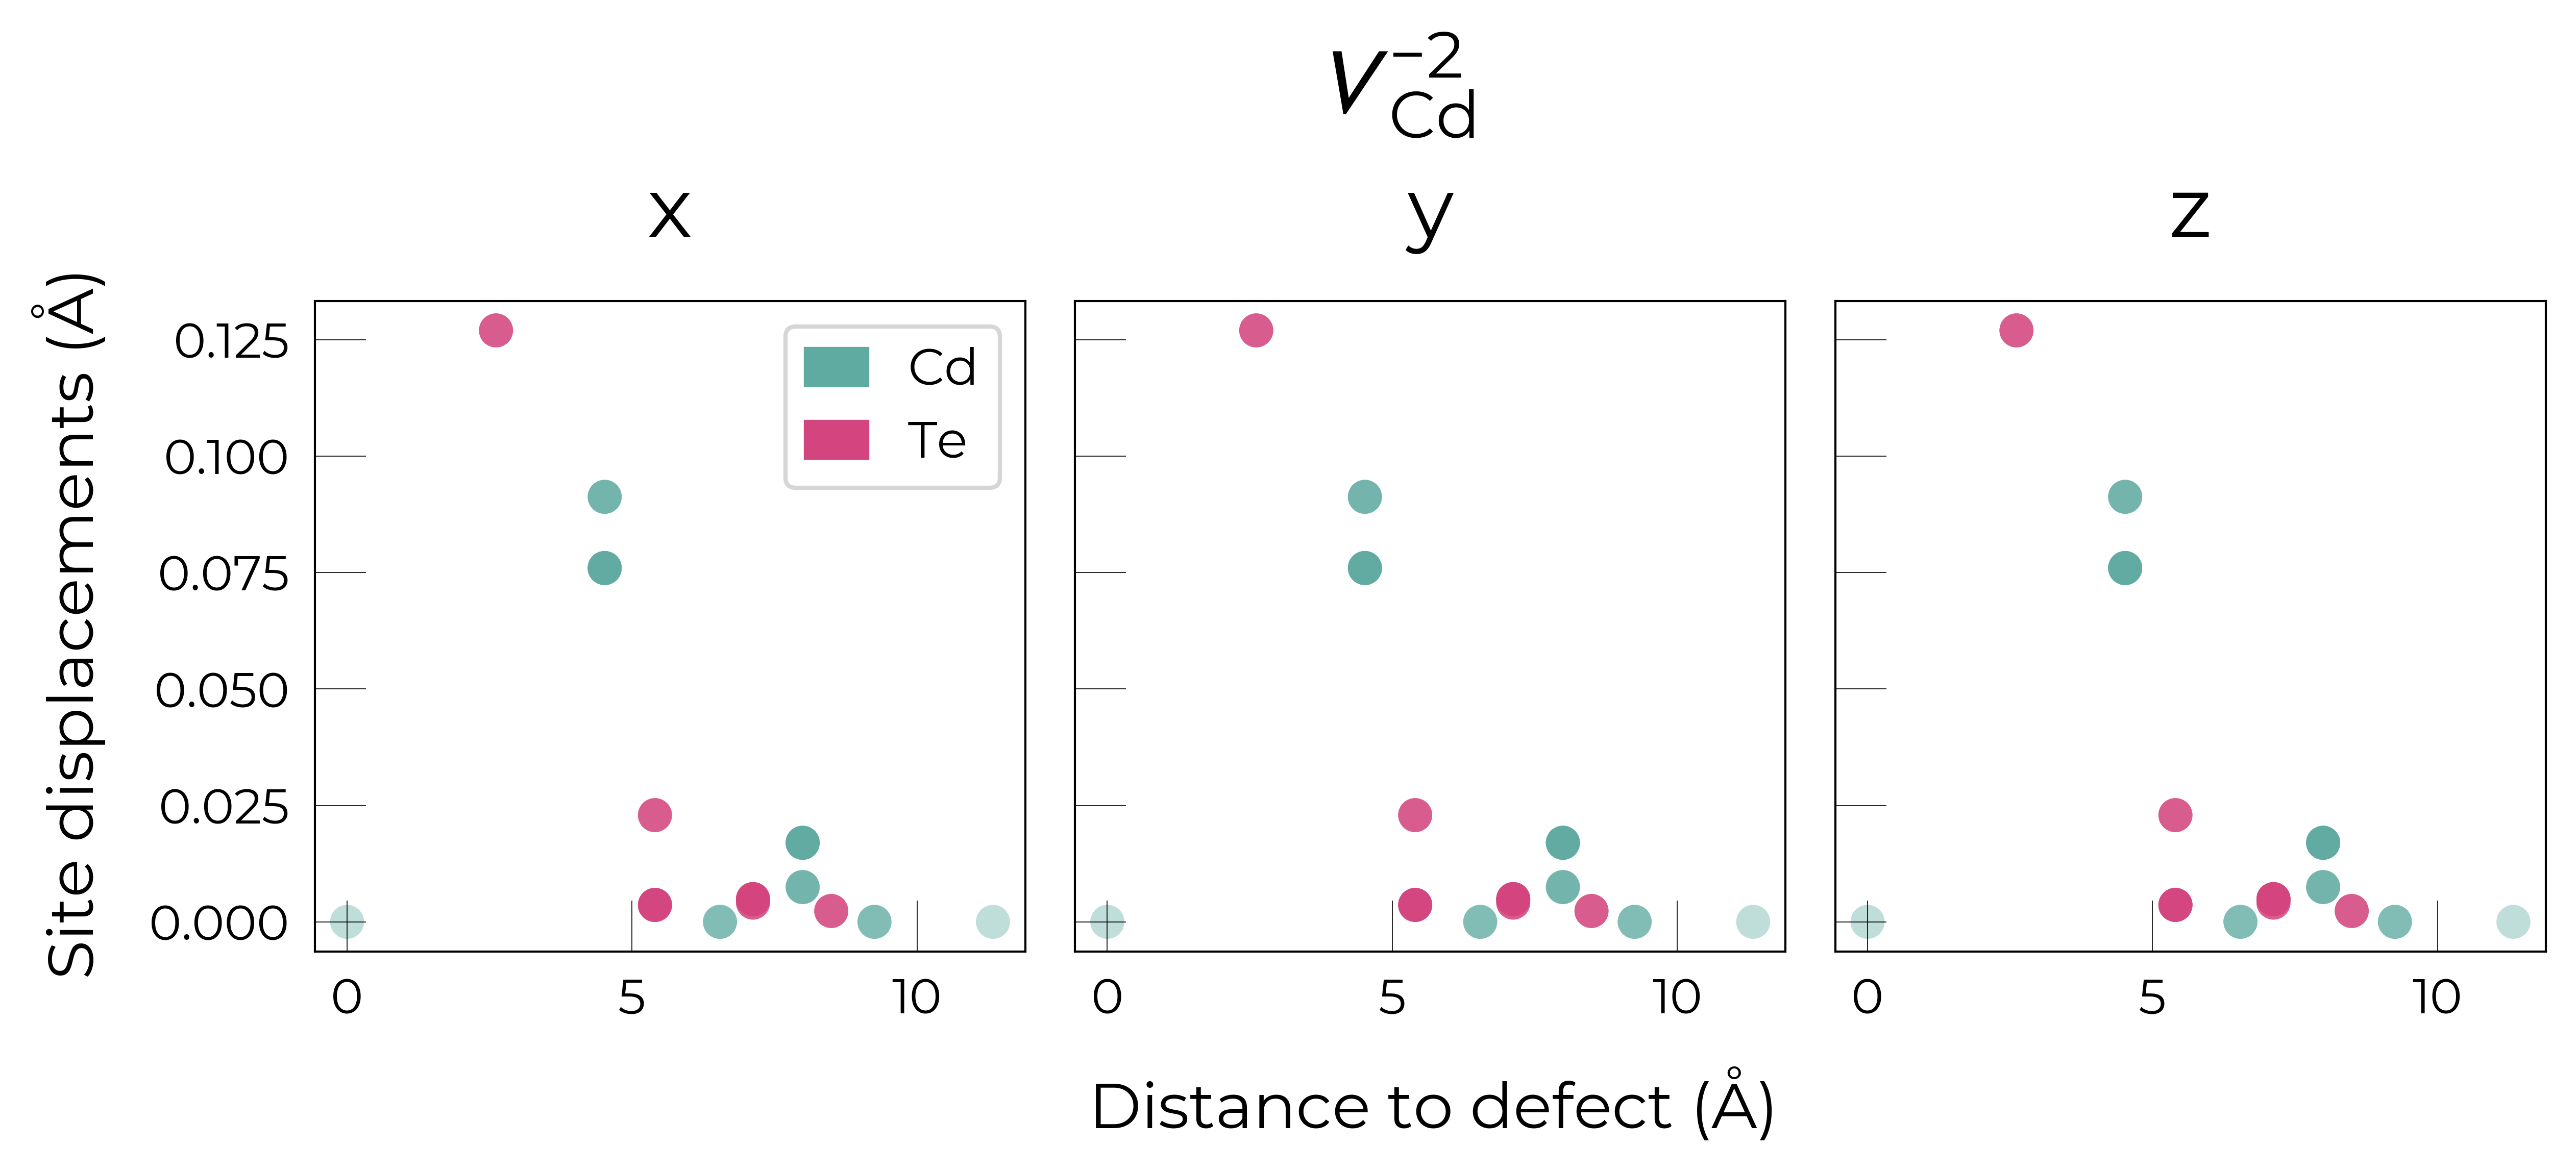

In [3]:
for defect_entry in v_Cd_entries:
    fig = defect_entry.plot_site_displacements(separated_by_direction=True)
    fig.suptitle(format_defect_name(defect_entry.name, include_site_info_in_name=False),
                 y=1.2, fontsize=22)

Here we see that $V_{Cd}^{-2}$ has isotropic (symmetric) displacements of atoms around the vacancy site in the x/y/z directions, which makes sense as it adopts a tetrahedral (`Td`) geometry (as shown in the `get_symmetries_and_degeneracies` output below and discussed in detail in [this paper](https://pubs.acs.org/doi/10.1021/acsenergylett.1c00380)).
As expected, we see an exponential tail-off in the site displacement magnitudes as we move away from the defect, and it is the Te nearest neighbours which are most strongly perturbed.

For $V_{Cd}^{-1}$, we have a [Jahn-Teller-distorted](https://pubs.acs.org/doi/10.1021/acsenergylett.1c00380) $C_{3v}$ geometry where a neighbouring Te atom displaces along the [111] direction away from the vacancy site (while the other Te atoms displace towards the vacancy but by a smaller degree), while for $V_{Cd}^{0}$, we have a $C_{2v}$ geometry where two neighbouring Te displace significantly towards the vacancy and each other (~1 Å) forming a dimer bond, while the other two Te move a smaller distance towards the vacancy (~0.2 Å) as seen in the displacement plots and illustrated below.

In [4]:
from doped.thermodynamics import DefectThermodynamics
v_Cd_thermo = DefectThermodynamics(v_Cd_entries)
v_Cd_thermo.get_symmetries_and_degeneracies()

,Defect,q,Site_Symm,Defect_Symm,g_Orient,g_Spin,g_Total,Mult
0,v_Cd,0,Td,C2v,6.0,1,6.0,1.0
1,v_Cd,-1,Td,C3v,4.0,2,8.0,1.0
2,v_Cd,-2,Td,Td,1.0,1,1.0,1.0



<img src="../examples/CdTe/V_Cd_geometries.jpeg" width="400"/>

The high symmetry of $V_{Cd}^{-2}$ is evident from the displacement plots above, where it looks like there are much fewer atoms in the plots, however this is just because we have many symmetry-equivalent atoms in this case and so we end up with many overlapping points (and so much less distinct points). Then for $C_{3v}$ $V_{Cd}^{-1}$ we have more distinct sites appearing, and then more so for the lower-symmetry $C_{2v}$ $V_{Cd}^{0}$ structure.

Instead of plotting the *absolute* displacements in the x, y, z directions, we can also plot the  displacements of atoms *relative* to the defect site (i.e. displacement of the atom along the line connecting itself to the defect). A negative displacement indicates that the atom moves towards the defect (compressive strain) while a positive displacement indicates that the atom moves away from the defect (tensile strain):

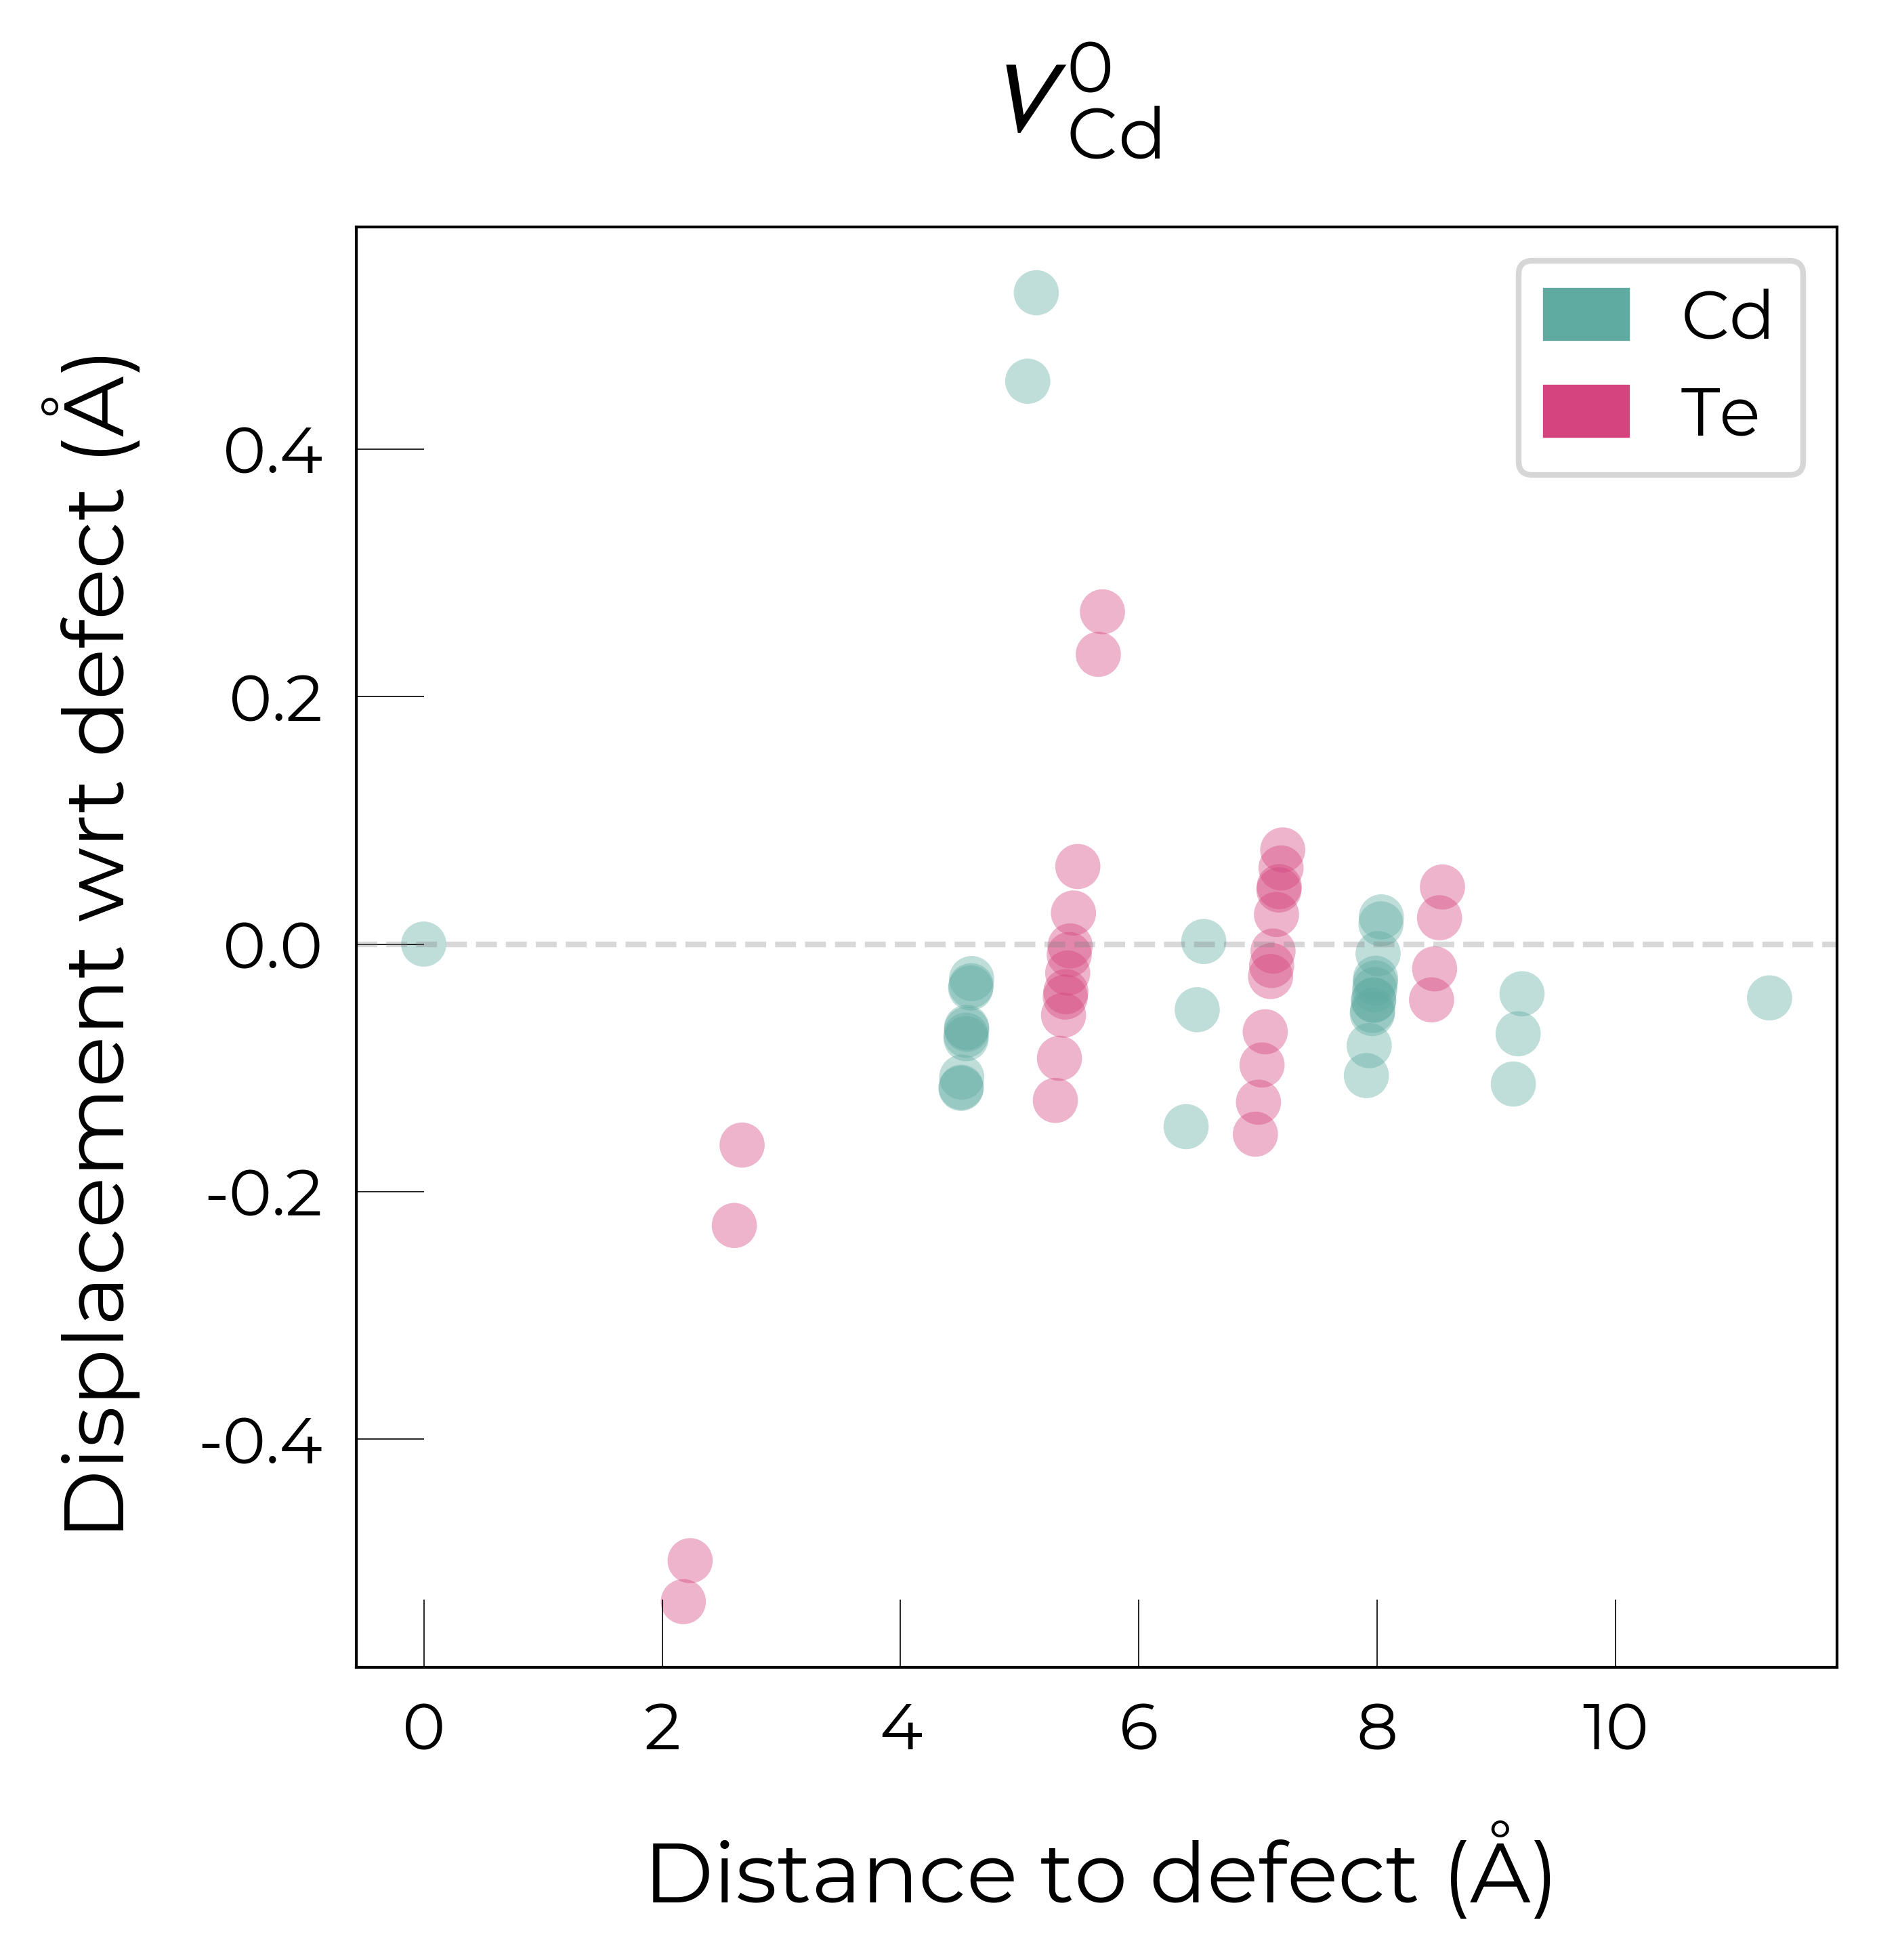

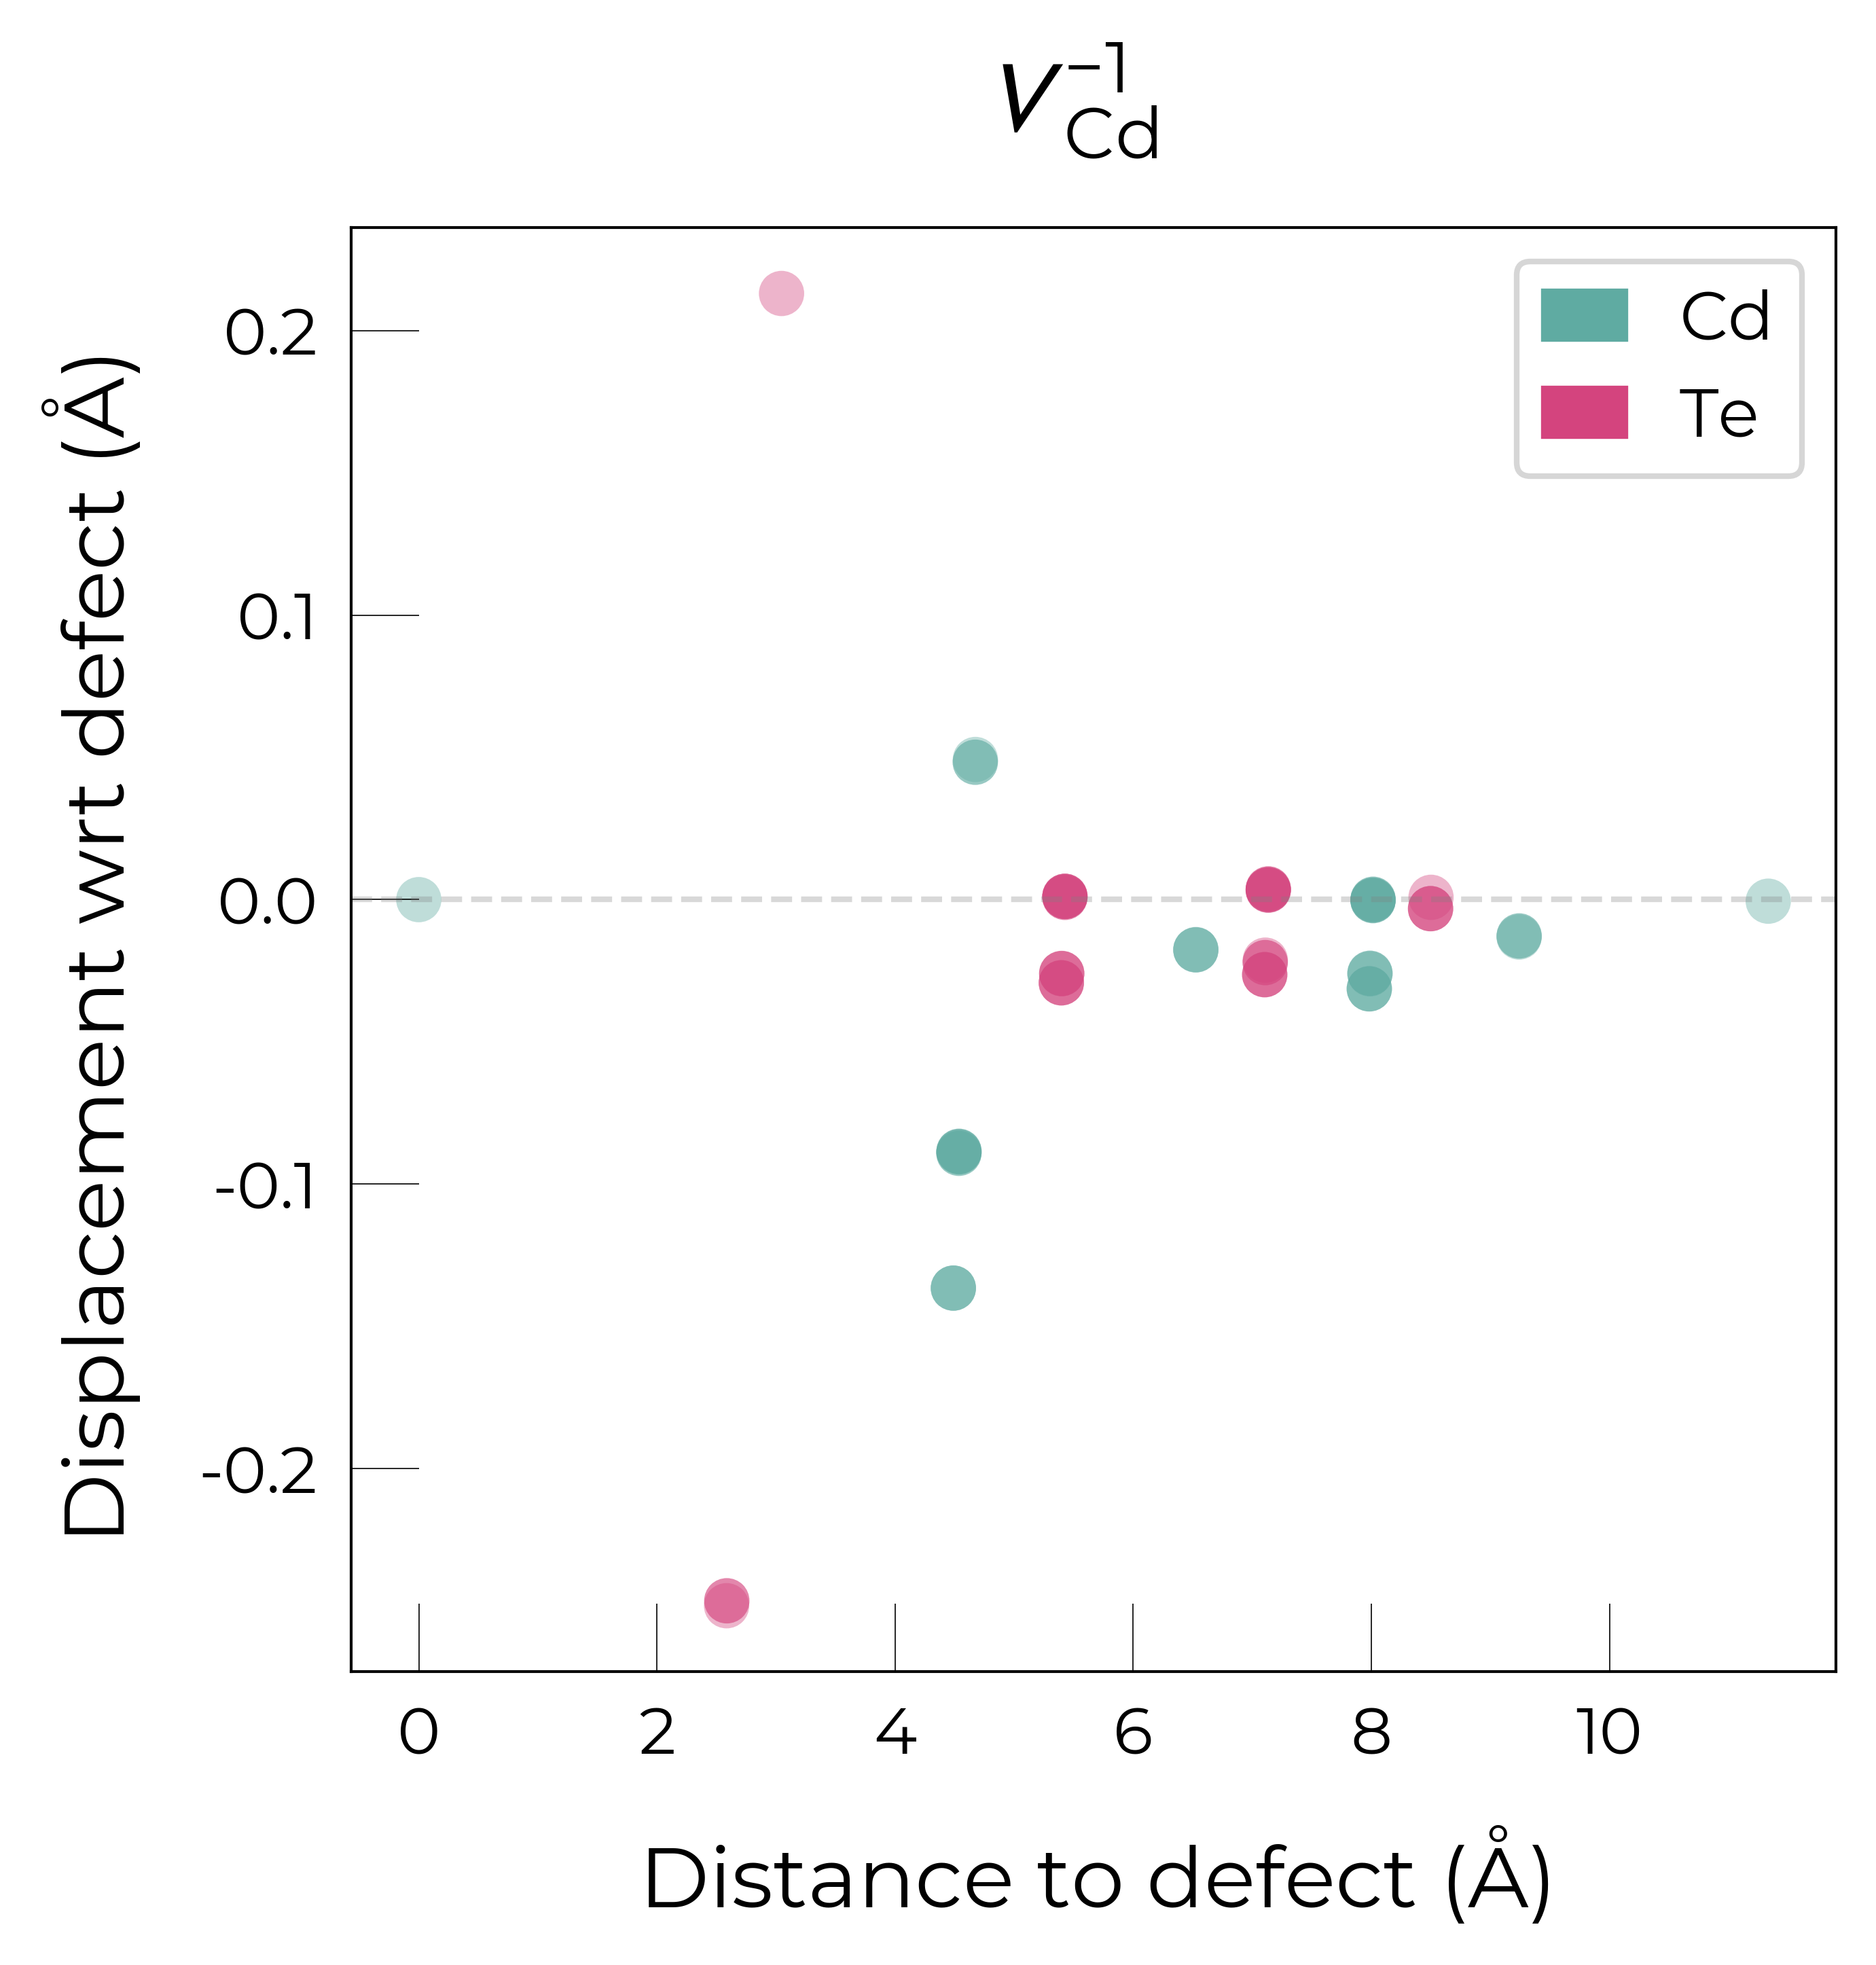

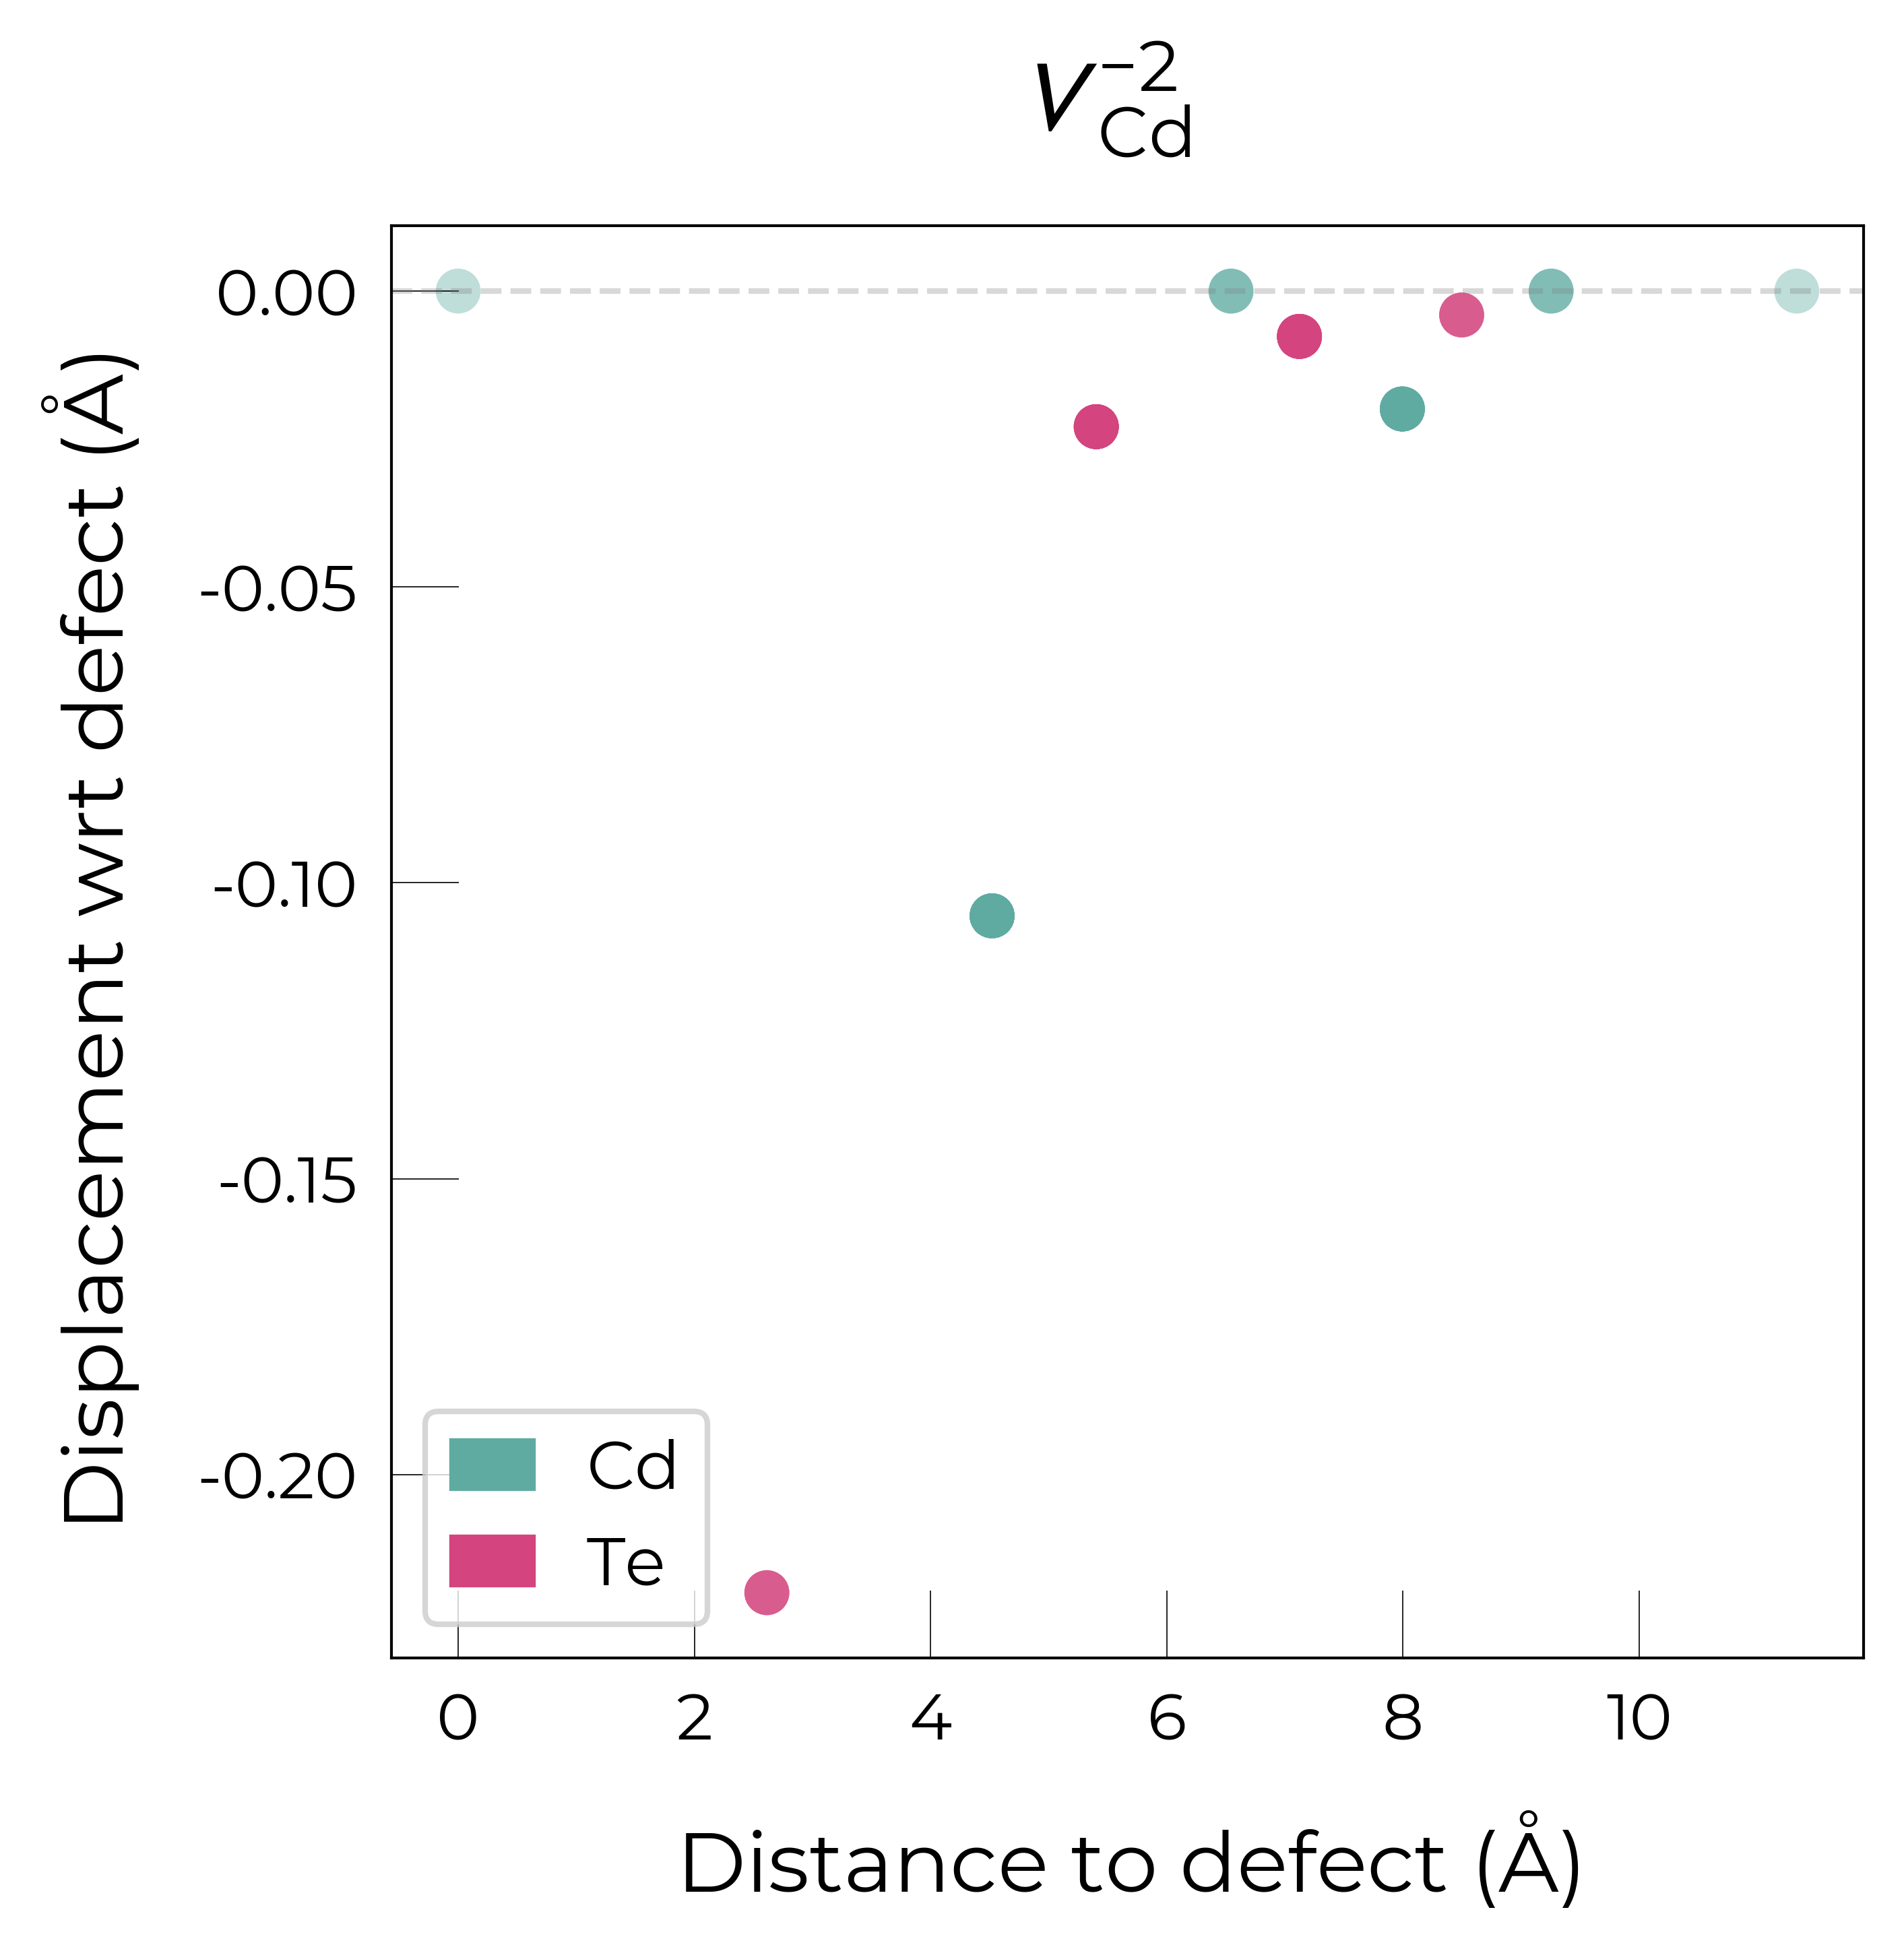

In [5]:
for defect_entry in v_Cd_entries:
    fig = defect_entry.plot_site_displacements(relative_to_defect=True)
    fig.suptitle(format_defect_name(defect_entry.name, include_site_info_in_name=False),
                 fontsize=18)

The above plots clearly show the different reconstructions of each charge state:
* The formation of the neutral vacancy introduces two holes which localise in the Te-Te dimer. These Te atoms forming the dimer displace significantly towards the defect, while the two other NN Te atoms also move towards the vacancy, but to a smaller degree.
* The singly charged vacancy introduces a single hole which localises in one of the Te NNs. This Te atom displaces away from the vacancy in the (-1,-1,-1) direction, while the other 3 Te atoms displace towards the vacancy.
* The doubly charged vacancy keeps the $T_d$ symmetry, with the 4 Te NNs displacing towards the vacancy by 0.2 Å (from the original Cd-Te bond distance of 2.83 Å to a distance of 2.61 Å) to allow for greater hybridization between dangling bonds.

Finally, we can also analyse the displacements along a specific direction. For instance, for the $V_{Cd}^{-1}$ defect, we can plot the displacements of atoms along the (-1, -1, -1) direction (the vector along which one of the Te NNs displaces away from the vacancy):

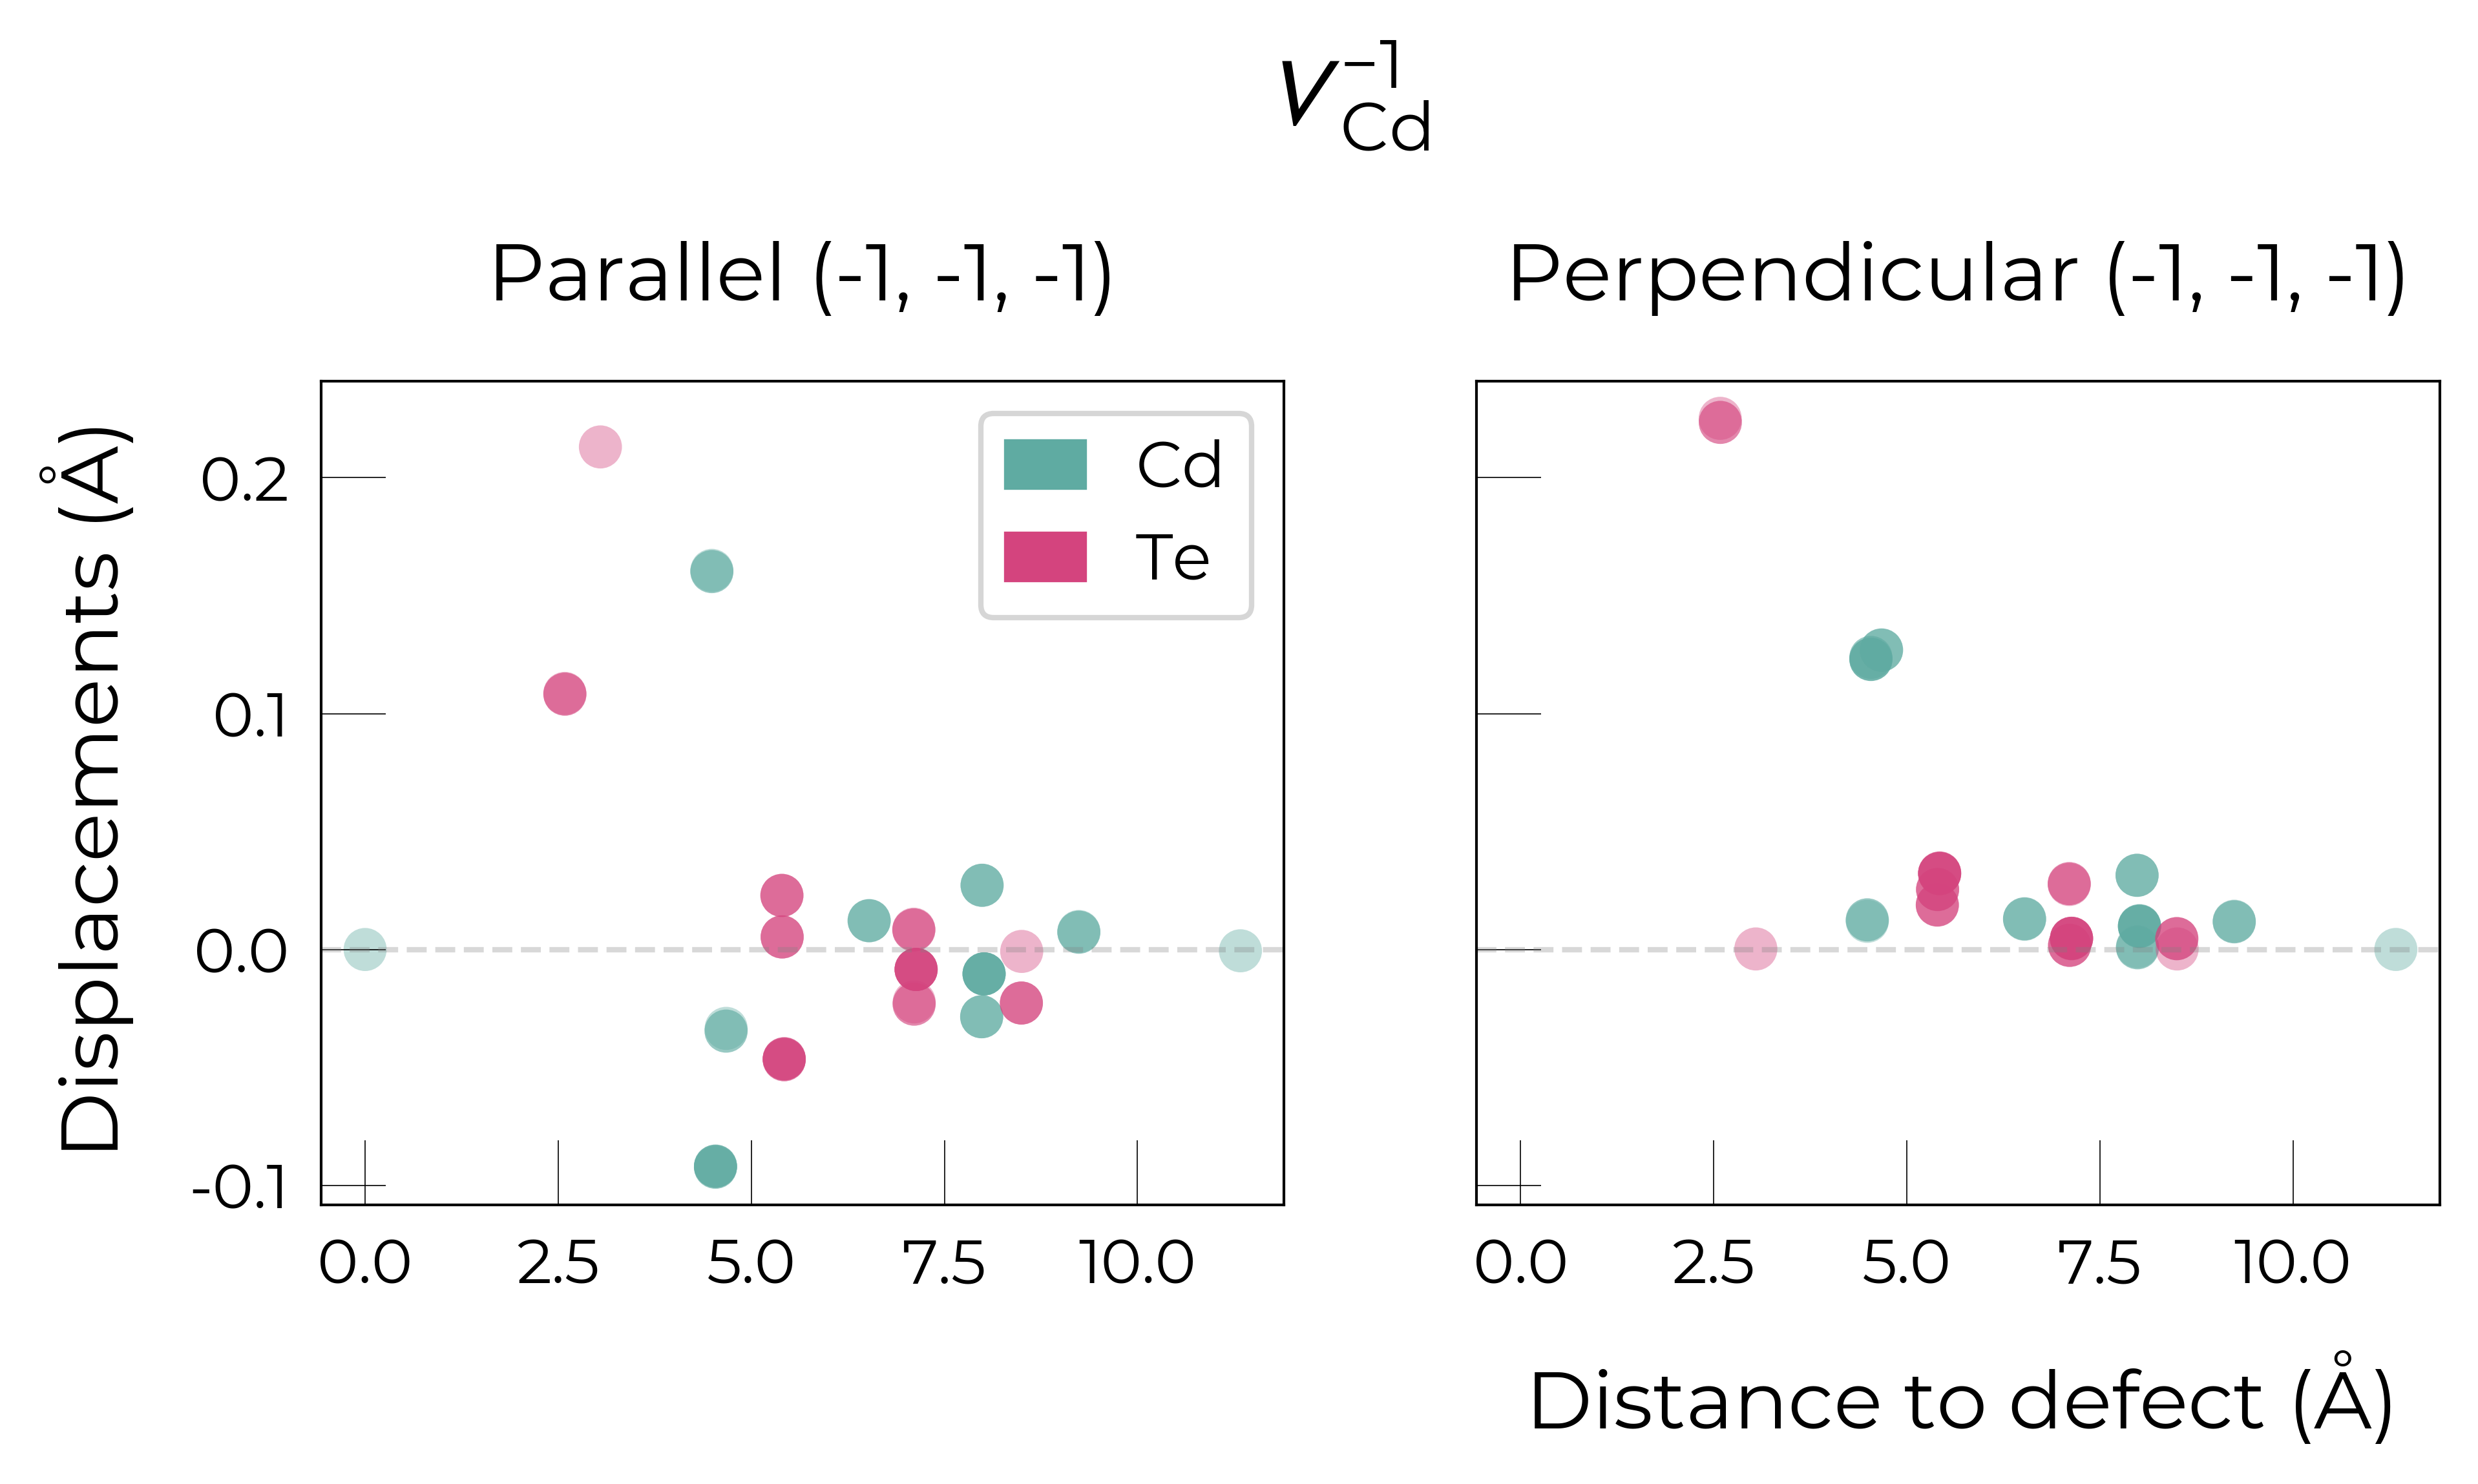

In [3]:
defect_entry = v_Cd_entries[1]
fig = defect_entry.plot_site_displacements(vector_to_project_on=[-1,-1,-1])
_ = fig.suptitle(format_defect_name(defect_entry.name, include_site_info_in_name=False),
                y=1.2, fontsize=18)

which shows how one of the Te NNs displaces in the (-1,-1,-1) direction away from the vacancy, while the other 3 Te atoms displace mostly perpendicular to this direction (overlaped points in the right plot at a distance of 2.5 Å). This is also shown when orienting the defect environment along the (-1,-1,-1) direction, where we see that the Te atom behind the vacancy (in shaded black) has displaced away from the vacancy (from an original distance of 2.8 to 3.0 Å).

<img src="../examples/CdTe/v_Cd_-1_oeriented_along_m1m1m1.png" width="400"/>

Similarly, for the neutral case, we can plot the displacements along the vector connecting the Te dimer ((1,1,0) vector). This will show two Te atoms significantly displacing along this vector, but in opposite directions (moving towards each other to form the dimer bond):

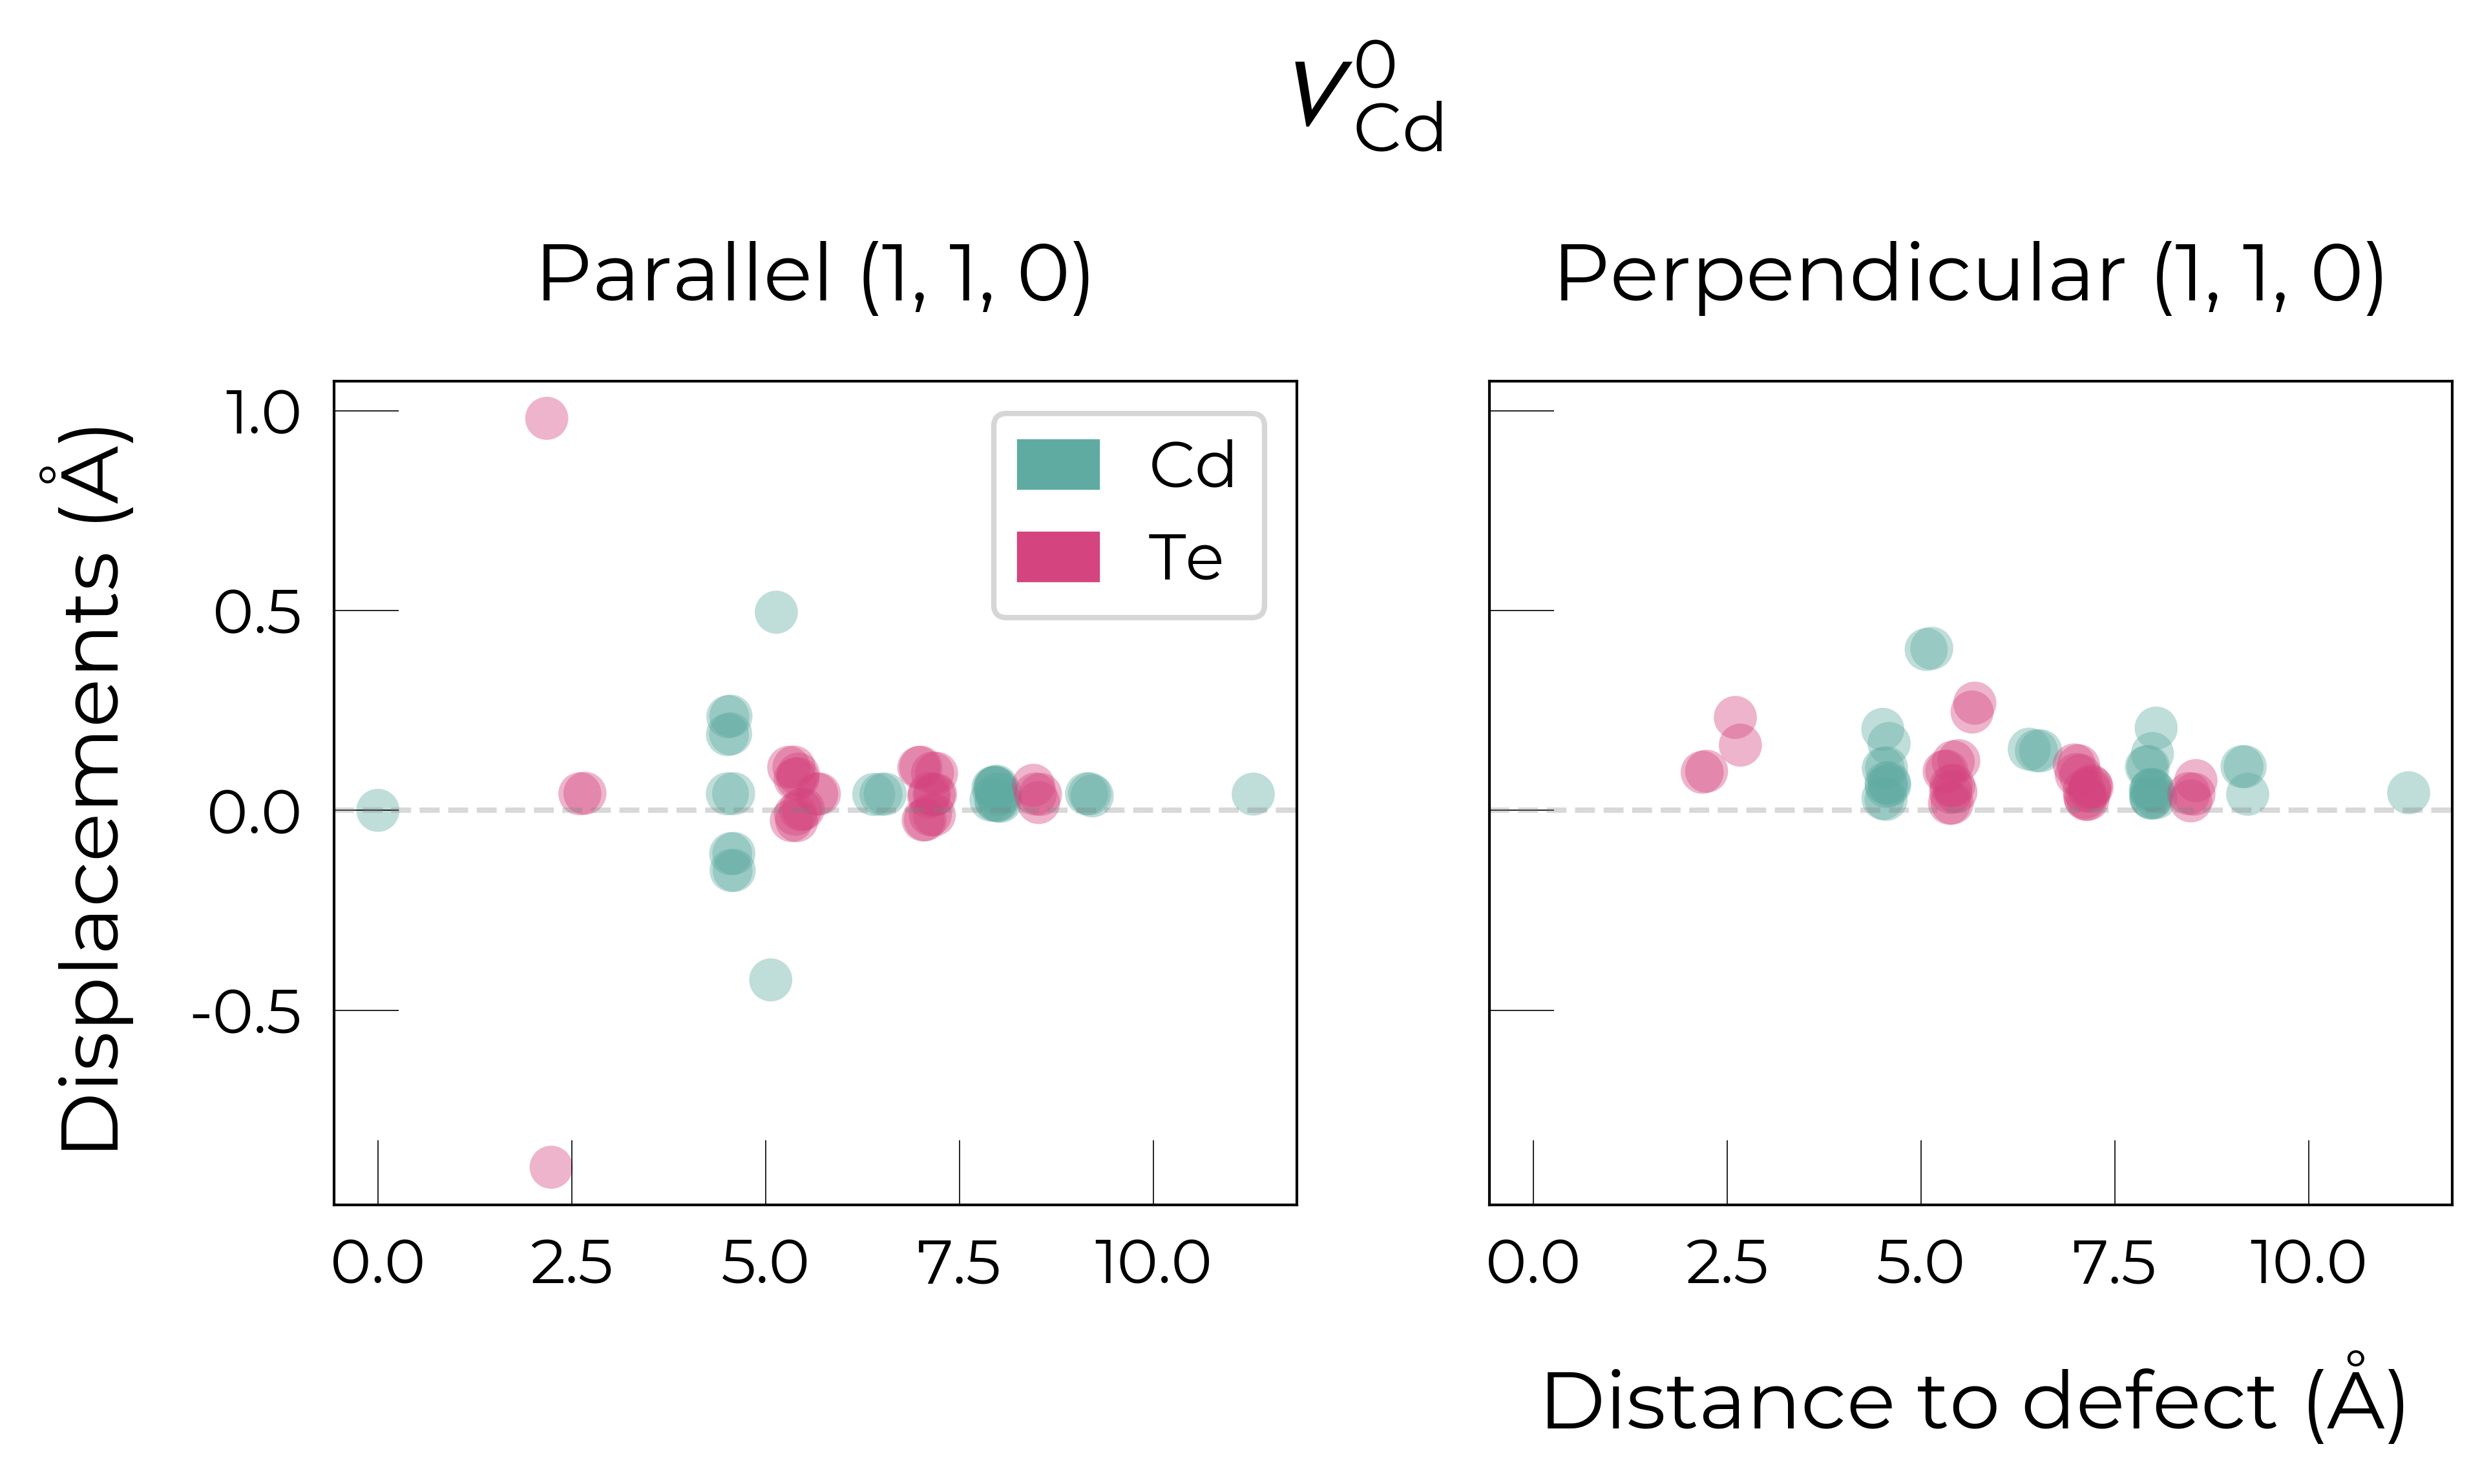

In [4]:
defect_entry = v_Cd_entries[0]  # Neutral state
vector_to_project_on = [1,1,0]  # Vector connecting Te dimer
fig = defect_entry.plot_site_displacements(vector_to_project_on=vector_to_project_on)
_ = fig.suptitle(format_defect_name(defect_entry.name, include_site_info_in_name=False),
                y=1.2, fontsize=18)

which indeed shows one Te moving by 1 Å along the (1,1,0) direction while the other Te moves by ~0.9 Å along the (-1,-1,0) direction, reducing the original Te-Te bond distance from 4.63 Å to 2.75 Å. This can also be visualised by orienting the defect environment along the (1,1,0) direction:

<img src="../examples/CdTe/v_Cd_0_oriented_along_110.png" width="400"/>

```{note}
The data for the atomic site displacements in the relaxed defect supercell is stored in the `DefectEntry.calculation_metadata["site_displacements"]` attributes, which has a dictionary of site displacement vectors (relative to the unperturbed bulk positions) and their (relaxed) distances to the defect site, ordered by the site indices in the defect sueprcell structure.
```

## Custom Supercell Generation

Here we'll illustrate some of the ways in which we can customise the supercell generation process for defect calculations in `doped`, including:
- Generation of optimal supercell based on minimum image distance and atom number constraints (`doped` default)
- Manual generation of an arbitrary supercell
- Enforced (near-)cubic supercell
- Enforced diagonal expansion

We'll use silicon (the "go-to") as our example host material here.

### Optimal Supercell (Default)

When choosing a simulation supercell for charged defects in materials, we typically want to maximise the minimum distance between periodic images of the defect (to reduce finite-size errors) while keeping the supercell to a tractable number of atoms/electrons to calculate. 

As detailed in the JOSS paper, `doped` integrates an efficient algorithm for calculating minimum image distances and (if no specific supercell is chosen) then directly optimises the supercell choice for this goal – often identifying non-trivial 'root 2'/'root 3' type supercells. This leads to a significant reduction in the supercell size (and thus computational cost) required to achieve a threshold minimum image distance (mean improvements of 7-35% in minimum image distance compared `pymatgen`/`ASE` functions). Let's see this in action: 

In [52]:
from doped.generation import DefectsGenerator
from pymatgen.core.structure import Structure

si_poscar = Structure.from_file("../tests/data/Si_MP_conv_POSCAR")
defect_gen = DefectsGenerator(si_poscar)

Generating DefectEntry objects: 100.0%|██████████| [00:12,   7.82it/s]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Si         [+1,0,-1]          [0.000,0.000,0.000]  8a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Si_i_D3d         [+4,+3,+2,+1,0]    [0.625,0.625,0.625]  16d
Si_i_Td          [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  8b

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 8 formula unit(s) of Si.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [53]:
defect_gen.supercell_matrix  # show the supercell matrix identified

array([[3., 0., 0.],
       [0., 3., 0.],
       [0., 0., 3.]])

In [54]:
print(f"Here `doped` identifies a 3x3x3 expansion of the primitive unit cell as the optimal supercell for diamond-like silicon (giving a FCC-like supercell), having a minimum image distance of {defect_gen.min_image_distance:.2f} Å with {defect_gen.bulk_supercell.num_sites} atoms, satisfying the default minimum image distance and atom number constraints of 10 Å and 50 atoms respectively.")

Here `doped` identifies a 3x3x3 expansion of the primitive unit cell as the optimal supercell for diamond-like silicon (giving a FCC-like supercell), having a minimum image distance of 11.55 Å with 54 atoms, satisfying the default minimum image distance and atom number constraints of 10 Å and 50 atoms respectively.


```{note}
``DefectsGenerator.supercell_matrix`` is defined with respect to the `primitive` unit cell of the host material, which may differ from the input structure (if it's not the primitive cell).
```

In [16]:
# these default constraints and behaviour are noted in the docstring, which can be printed with:
DefectsGenerator?

Ok, so maybe we have a case where we want to be stricter with our minimum image distance requirement, and want to set it to 13 Å, and also make sure we have at least 120 atoms in the supercell. We can do this by just setting the `min_image_distance` and `min_atoms` entries in `supercell_gen_kwargs` with `DefectsGenerator`:

In [55]:
defect_gen = DefectsGenerator(si_poscar, 
                              supercell_gen_kwargs={"min_image_distance": 13, "min_atoms": 120})

Generating DefectEntry objects: 100.0%|██████████| [00:14,   6.99it/s]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Si         [+1,0,-1]          [0.000,0.000,0.000]  8a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Si_i_D3d         [+4,+3,+2,+1,0]    [0.625,0.625,0.625]  16d
Si_i_Td          [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  8b

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 8 formula unit(s) of Si.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [56]:
defect_gen.supercell_matrix  # show the supercell matrix identified

array([[4., 0., 0.],
       [0., 4., 0.],
       [0., 0., 4.]])

In [57]:
print(f"Here `doped` identifies a 4x4x4 expansion of the primitive unit cell as the optimal supercell for diamond-like silicon (giving a FCC-like supercell), having a minimum image distance of {defect_gen.min_image_distance:.2f} Å with {defect_gen.bulk_supercell.num_sites} atoms, satisfying our updated minimum image distance and atom number constraints of 13 Å and 120 atoms respectively.")

Here `doped` identifies a 4x4x4 expansion of the primitive unit cell as the optimal supercell for diamond-like silicon (giving a FCC-like supercell), having a minimum image distance of 15.40 Å with 128 atoms, satisfying our updated minimum image distance and atom number constraints of 13 Å and 120 atoms respectively.


As detailed in the `DefectsGenerator` docstring, there is also the `ideal_threshold = x` parameter, which allows a supercell larger by a fraction `x` (default = 0.1 = 10%) than that which satisfies the min image distance / atom number constraints, _if_ it is a perfect diagonal expansion of the primitive or conventional cell (because diagonal expansions often help simplify things like visualisation, symmetry analysis, finite-size error cancellation etc., so are typically preferred if the additional computational cost is relatively low). 

But as always, this parameter can be adjusted. Perhaps we don't care about this and just want the minimum supercell size that satisfies our min image distance / atom number constraints; we can just set this to 0:   

In [58]:
defect_gen = DefectsGenerator(si_poscar, 
                              supercell_gen_kwargs={"min_image_distance": 13, 
                                                    "ideal_threshold": 0})

Generating DefectEntry objects: 100.0%|██████████| [00:16,   5.91it/s]                             

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Si         [+1,0,-1]          [0.000,0.000,0.000]  8a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Si_i_D3d         [+4,+3,+2,+1,0]    [0.625,0.625,0.625]  16d
Si_i_Td          [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  8b

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 8 formula unit(s) of Si.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [59]:
defect_gen.supercell_matrix  # show the supercell matrix identified

array([[-4.,  2.,  2.],
       [ 2., -4.,  2.],
       [ 2.,  2.,  0.]])

In [60]:
print(f"Here `doped` identifies a non-diagonal (non-FCC) expansion of the primitive unit cell as the optimal supercell for diamond-like silicon, having a minimum image distance of {defect_gen.min_image_distance:.2f} Å with {defect_gen.bulk_supercell.num_sites} atoms, satisfying our minimum image distance constraint of 13 Å, with no testing of larger supercells which may give diagonal expansions.")

Here `doped` identifies a non-diagonal (non-FCC) expansion of the primitive unit cell as the optimal supercell for diamond-like silicon, having a minimum image distance of 13.33 Å with 96 atoms, satisfying our minimum image distance constraint of 13 Å, with no testing of larger supercells which may give diagonal expansions.


Of course, we could also increase `ideal_threshold` from the default `0.1` if we were particularly keen on adopting diagonal supercell expansions when possible. If we only want diagonal supercell expansions, we can just set `force_diagonal: True` in `supercell_gen_kwargs`. 

### Manual Supercell Generation

Often we may be trying to perform defect calculations following a pre-defined workflow – from a paper in the literature or a previous project for instance. In these cases, to remove potential sources of variance in the results, we may want to ensure we're using the exact same supercell specification, which may not be the optimal supercell for that system. 

To use a specific supercell in `doped`, we can just load or generate this supercell manually and then input this structure to `DefectsGenerator` along with `generate_supercell = False`, in which case it will use the input structure as the supercell:  

In [49]:
si_custom_supercell = si_poscar * [3, 2, 3]  # e.g. a 3x2x3 supercell
defect_gen = DefectsGenerator(si_custom_supercell, generate_supercell=False)

Generating DefectEntry objects: 100.0%|██████████| [00:07,  14.08it/s]

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Si         [+1,0,-1]          [0.000,0.000,0.000]  8a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Si_i_D3d         [+4,+3,+2,+1,0]    [0.625,0.625,0.625]  16d
Si_i_Td          [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  8b

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 8 formula unit(s) of Si.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [50]:
defect_gen.supercell_matrix  # show the supercell matrix

array([[-3.,  3.,  3.],
       [ 2., -2.,  2.],
       [ 3.,  3., -3.]])

As mentioned above `DefectsGenerator.supercell_matrix` is defined with respect to the _primitive_ unit cell of the host material rather than the input structure (which does not need to be the primitive cell). Here our original structure was the conventional cell of diamond-like silicon, and so a 3x2x3 expansion of it corresponds to a supercell matrix of `[[-3, 3, 3], [2, -2, 2], [3, 3, -3]]` with respect to the primitive cell.

In [51]:
print(f"Here our custom supercell has a minimum image distance of {defect_gen.min_image_distance:.2f} Å with {defect_gen.bulk_supercell.num_sites} atoms.")

Here our custom supercell has a minimum image distance of 10.89 Å with 144 atoms.


### Enforced (Near-)Cubic Supercell

If we want to enforce generation of a (near-)cubic supercell, we can just set `force_cubic: True` in `supercell_gen_kwargs`. This will generate the smallest supercell that is cubic or near-cubic (i.e. where the lattice vectors are all within a certain tolerance of each other) that also satisfies the minimum image distance and atom number constraints.

In [61]:
defect_gen = DefectsGenerator(si_poscar, 
                              supercell_gen_kwargs={"force_cubic": True})

Generating DefectEntry objects: 100.0%|██████████| [00:07,  14.18it/s]

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Si         [+1,0,-1]          [0.000,0.000,0.000]  8a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Si_i_D3d         [+4,+3,+2,+1,0]    [0.625,0.625,0.625]  16d
Si_i_Td          [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  8b

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 8 formula unit(s) of Si.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [62]:
defect_gen.supercell_matrix  # show the supercell matrix wrt primitive cell

array([[-2,  2,  2],
       [ 2, -2,  2],
       [ 2,  2, -2]])

In [63]:
print(f"Here our enforced-cubic supercell has a minimum image distance of {defect_gen.min_image_distance:.2f} Å with {defect_gen.bulk_supercell.num_sites} atoms.")

Here our enforced-cubic supercell has a minimum image distance of 10.89 Å with 64 atoms.


In [64]:
defect_gen.bulk_supercell.lattice  # show the lattice vectors, cubic as expected

Lattice
    abc : 10.8874 10.8874 10.8874
 angles : 90.0 90.0 90.0
 volume : 1290.5431714516237
      A : 10.8874 0.0 0.0
      B : 0.0 10.8874 0.0
      C : 0.0 0.0 10.8874
    pbc : True True True

### Enforced Diagonal Expansion

If we only want to allow diagonal supercell expansions (of the primitive cell), we can just set `force_diagonal: True` in `supercell_gen_kwargs`. This will generate the smallest supercell with a diagonal expansion matrix that also satisfies the minimum image distance and atom number constraints:

In [65]:
defect_gen = DefectsGenerator(si_poscar, 
                              supercell_gen_kwargs={"force_diagonal": True})

Generating DefectEntry objects: 100.0%|██████████| [00:07,  13.55it/s]

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Si         [+1,0,-1]          [0.000,0.000,0.000]  8a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Si_i_D3d         [+4,+3,+2,+1,0]    [0.625,0.625,0.625]  16d
Si_i_Td          [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  8b

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 8 formula unit(s) of Si.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standard structure, for which doped uses the spglib convention.


In [66]:
defect_gen.supercell_matrix  # show the supercell matrix wrt primitive cell

array([[3, 0, 0],
       [0, 3, 0],
       [0, 0, 3]])

Here we get the same supercell expansion as in our first example case with silicon above, as it found that a diagonal expansion of our FCC-like primitive cell gave the optimal supercell under the default minimum image distance and atom number constraints.

In [68]:
print(f"Here `doped` identifies a 3x3x3 expansion of the primitive unit cell as the optimal supercell for diamond-like silicon (giving a FCC-like supercell), having a minimum image distance of {defect_gen.min_image_distance:.2f} Å with {defect_gen.bulk_supercell.num_sites} atoms, satisfying the default minimum image distance and atom number constraints of 10 Å and 50 atoms respectively.")

Here `doped` identifies a 3x3x3 expansion of the primitive unit cell as the optimal supercell for diamond-like silicon (giving a FCC-like supercell), having a minimum image distance of 11.55 Å with 54 atoms, satisfying the default minimum image distance and atom number constraints of 10 Å and 50 atoms respectively.


## Point Symmetry Analysis

As shown in the thermodynamics analysis tutorial, if we have parsed our defect calculations with ``doped``, we can automatically determine the corresponding point symmetries of the relaxed defect and original bulk site, which gives us the orientational degeneracy factor for the defect concentrations (regardless of whether the calculation inputs were generated with ``doped``) – as shown below:

In [3]:
from monty.serialization import loadfn
CdTe_thermo = loadfn("CdTe/CdTe_LZ_thermo_wout_meta.json")  # load our DefectThermodynamics object
CdTe_thermo.get_symmetries_and_degeneracies()

,Defect,q,Site_Symm,Defect_Symm,g_Orient,g_Spin,g_Total,Mult
0,v_Cd,0,Td,C2v,6.0,1,6.0,1.0
1,v_Cd,-1,Td,C3v,4.0,2,8.0,1.0
2,v_Cd,-2,Td,Td,1.0,1,1.0,1.0
3,v_Te,+2,Td,Td,1.0,1,1.0,1.0
4,v_Te,+1,Td,Td,1.0,2,2.0,1.0
5,v_Te,0,Td,C2v,6.0,1,6.0,1.0
6,v_Te,-1,Td,Cs,12.0,2,24.0,1.0
7,v_Te,-2,Td,Cs,12.0,1,12.0,1.0
8,Cd_Te,+2,Td,Td,1.0,1,1.0,1.0
9,Cd_Te,+1,Td,C2v,6.0,2,12.0,1.0


```{note}
The product of the defect degeneracy factors (such as orientational and spin, which are automatically computed by `doped`) and site multiplicity determine the pre-factor is used in the calculation of defect/carrier concentrations (and thus doping / Fermi level behaviour). For more explanation and discussion of this, see e.g. [_Impact of metastable defect structures on carrier recombination in solar cells_](https://doi.org/10.1039/D2FD00043A) & [_Imperfections are not 0 K: free energy of point defects in crystals_](https://doi.org/10.1039/D3CS00432E).
```

However, we can also directly use the `point_symmetry` function from `doped.utils.symmetry` (see the [docstring](https://doped.readthedocs.io/en/latest/doped.utils.html#doped.utils.symmetry.point_symmetry) in the python API docs) to obtain the relaxed or unrelaxed (bulk site) point symmetries of a given defect supercell, directly from just the relaxed structures, regardless of whether these defects were generated/parsed with ``doped``:

In [3]:
from doped.utils.symmetry import point_symmetry
from pymatgen.core.structure import Structure

relaxed_defect_supercell = Structure.from_file("YTOS/Int_F_-1/Relaxed_CONTCAR")
print(point_symmetry(relaxed_defect_supercell))

C4v


```{note}
**Note:** It should be noted that the point symmetry analysis is not guaranteed to work in all cases; namely for certain non-trivial supercell expansion matrices (e.g. a 2x1x2 expansion)(particularly with high-symmetry materials) which can break the periodicity of the cell. With the standard `doped` parsing functions (via `DefectThermodynamics`), `doped` will automatically check if this is the case, and will warn you if so. If you are using `point_symmetry` directly, then you can also provide the reference host supercell (with `bulk_structure`, as shown below) and `doped` will check this.

If periodicity-breaking does prevent auto-symmetry determination, you can manually determine the relaxed defect and bulk-site point symmetries, and/or orientational degeneracy, from visualising the structures (e.g. using VESTA)(can use `get_orientational_degeneracy` to obtain the corresponding orientational degeneracy factor for given defect/bulk-site point symmetries) and setting the corresponding values in the `calculation_metadata['relaxed point symmetry']/['bulk site symmetry']` and/or `degeneracy_factors['orientational degeneracy']` attributes.
```

In [4]:
relaxed_defect_supercell = Structure.from_file("YTOS/Int_F_-1/Relaxed_CONTCAR")
bulk_supercell = Structure.from_file("YTOS/Bulk/POSCAR")
print(point_symmetry(relaxed_defect_supercell, bulk_structure=bulk_supercell))

C4v


No warning is encountered here, so we can be confident that there is no periodicity breaking at play. With `bulk_structure` supplied, we can also get the bulk site symmetry of the defect (i.e. the symmetry at the unrelaxed defect site), by setting `relaxed=False`:  

In [5]:
print(point_symmetry(relaxed_defect_supercell, bulk_structure=bulk_supercell, relaxed=False))

Cs


## Processing Cdᵢ `vasp_gam` calculations to see which site is favoured

In [14]:
import os
from doped.analysis import DefectParser

bulk_path = "CdTe/CdTe_bulk/vasp_gam/"  # path to bulk (defect-free) supercell calculation
dielectric = 9.13  # calculated dielectric constant, required for computing defect charge corrections
Cd_i_dict = {}  # Keep dictionary of parsed defect entries

for i in os.listdir("CdTe"):
    if 'Cd_i' in i:
        Cd_i_dict[i] = DefectParser.from_paths(
            defect_path=f"CdTe/{i}/vasp_gam/", bulk_path=bulk_path, dielectric=dielectric).defect_entry

for defect_name, defect_entry in Cd_i_dict.items():
    print(f"Name: {defect_name}; Raw Supercell Energy: {defect_entry.get_ediff():.3f} eV")
    # note this energy is just the energy difference of the bulk and defect supercells (including
    # finite-size charge corrections if any – none here as they're neutral defects), without Fermi
    # level or chemical potential terms (though these are constant for the same defect & charge)

Name: Cd_i_Td_Cd2.83_0; Raw Supercell Energy: 0.592 eV
Name: Cd_i_C3v_0; Raw Supercell Energy: 0.728 eV
Name: Cd_i_Td_Te2.83_0; Raw Supercell Energy: 0.728 eV


Here we see that the Cd-coordinated interstitial site is the lowest energy for _neutral_ cadmium
interstitials here!

```{note}
The energies here do not yet account for the chemical potentials, which are included later in the
post-processing workflow (as shown earlier in this notebook). However, the chemical potential energy
correction is the same for each charge state or site, for a **_given defect_** (e.g. Cd<sub>i</sub>
here) - hence the relative energies are still meaningful here.
```

Here we see that `Cd_i_C3v_0` and `Cd_i_Td_Te2.83_0` have equal final energies (rounded to 1 meV/atom)
suggesting they have relaxed to the same final structure (despite different initial interstitial positions).
Let's use `StructureMatcher` and `local_env` to double-check:

In [24]:
# Here we use the pymatgen StructureMatcher class to compare the relaxed structures of neutral Cd_i:
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher()
print("Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_Td_Cd2.83_0'].defect_supercell, Cd_i_dict['Cd_i_C3v_0'].defect_supercell))
print("Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_C3v_0'].defect_supercell, Cd_i_dict['Cd_i_Td_Te2.83_0'].defect_supercell))

Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?: False
Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?: True


In [41]:
# we can perform further defect structural analysis with these functions:
from pymatgen.analysis.local_env import CrystalNN
import numpy as np

for key, defect_entry in Cd_i_dict.items():
    # get defect site index in structure: (needed for CrystalNN)
    for i, site in enumerate(defect_entry.defect_supercell.sites):
        if np.isclose(site.frac_coords, defect_entry.defect_supercell_site.frac_coords).all():
            isite = i  # site index, starting from 0

    crystalNN = CrystalNN()
    struct = defect_entry.defect_supercell
    struct.add_oxidation_state_by_guess()
    print("Local order parameters (i.e. resemblence to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ",
          crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct, isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ", bond_lengths, "\n")

Local order parameters (i.e. resemblence to given structural motif):  None
Nearest-neighbour dictionary:  {'Te0+': 6, 'Cd0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}] 

Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.08049643519922586, 'tetrahedral': 0.9999935468913711, 'rectangular see-saw-like': 0.007133072179242341, 'see-saw-like': 0.23547633536015408, 'trigonal pyramidal': 0.24644908542744104}
Nearest-neighbour dictionary:  {'Te0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.911'}, {'Ele

Here we see the structural similarity of "`Cd_i_C3v_0`" and "`Cd_i_Td_Te2.83_0`", showing that they have
 indeed relaxed to the same structure.
This means we only need to continue with one of these for the more expensive `vasp_std` and `vasp_ncl`
calculations with our full _k_-point mesh.

```{note}
If you want to do this coordination environment analysis with a vacancy, you may have to
introduce a fake atom at the vacancy position, in order to create a `pymatgen` `Site` object, to then use with `CrystalNN`.
For example:
```

In [24]:
from doped.thermodynamics import DefectThermodynamics
v_Cd_thermo = DefectThermodynamics(
    [entry for entry in CdTe_defects_thermo.defect_entries if "v_Cd" in entry.name],
    chempots=CdTe_defects_thermo.chempots
)  # only Cd vacancy defects

In [28]:
from pymatgen.analysis.local_env import CrystalNN
from doped.thermodynamics import bold_print

for defect_entry in v_Cd_thermo.defect_entries:
    bold_print(f"{defect_entry.name}, Charge State: {defect_entry.charge_state}")
    crystalNN = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False, search_cutoff=5)
    struct = defect_entry.defect_supercell.copy()
    struct.append('U', defect_entry.defect_supercell_site.frac_coords) # Add a fake element
    isite = len(struct.sites) - 1 # Starts counting from zero!

    print("Local order parameters (i.e. resemblance to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ", crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct,isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ",bond_lengths,"\n")

v_Cd_-2, Charge State: -2
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.07996848894580866, 'tetrahedral': 0.999999999996243, 'rectangular see-saw-like': 0.007024644113827354, 'see-saw-like': 0.23425369905750856, 'trigonal pyramidal': 0.24520967518806777}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}] 

v_Cd_-1, Charge State: -1
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.08955199275710107, 'tetrahedral': 0.9980437792997895, 'rectangular see-saw-like': 0.00914205834683717, 'see-saw-like': 0.2561471898083992, 'trigonal pyramidal': 0.2673736880526364}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.585'}, {'Element'